# Projet 09 - Prédire la demande en électricité

---

## <font color=blue>Sommaire</font>

[0. Préparation des données](data_analyst_projet09_M0_prepa_donnees.ipynb)  
  
[1. Corriger les données de consommation mensuelles de l'effet température](#1_0)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[1.1. Correction basée sur le calcul météo des dju](#1_1)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[1.2. Correction basée sur le calcul pro des dju](#1_2)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[1.3. Comparaison des résultats obtenus](#1_3)  
  
[2. Désaisonnaliser la consommation corrigée](#2_0)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.1. Observation de la série à désaisonnaliser](#2_0)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.2. Désaisonnalisation automatique](#2_2)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.3. Désaisonnalisation manuelle](#2_3)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.4. Désaisonnalisation avec l'algorithme x11](#2_4)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.5. Comparaison des courbes cvs obtenues avec les 3 méthodes](#2_5)  

[3. Prévoir la consommation sur un an](#3_0)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.1. Prévision par lissage exponentiel](#3_0)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.2. Prévision par une modélisation SARIMA](#3_2)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.2.1. Première analyse de la série temporelle](#3_2)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.2.2. Test d'un modèle ARIMA sans saisonnalité](#3_2_2)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.2.3. Test d'un modèle SARIMA](#3_2_3)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.3. Comparaison des estimations](#3_3)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.4. Graphiques spécifiques pour la présentation](#3_4)  

---
**Importation des librairies**

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import scipy.stats as st

import modules_perso.sf_times_series as sft
import modules_perso.sf_graphiques as sfg

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
#import warnings
#warnings.filterwarnings('ignore')

<a id='1_0'></a>

---
## <font color=blue>Mission 1 : Corriger les données de consommation mensuelles de l'effet température</font>

**Chargement des données**

In [4]:
consommation = pd.read_csv("donnees_projet09_2018.csv", parse_dates=["date"], index_col=0)
consommation.drop(columns=["chauffage_meteo_france","chauffage_pro_france"], inplace=True)
consommation.head()

date  consommation  chauffage_meteo_paris  chauffage_pro_paris
0 2010-01-31         56342           56137.501556         56429.792637
1 2010-02-28         48698           49785.584929         49822.682519
2 2010-03-31         48294           46014.134431         45899.710887
3 2010-04-30         38637           39562.969107         39602.309055
4 2010-05-31         37284           38371.984739         38311.857860

In [5]:
consommation.tail()

date  consommation  chauffage_meteo_paris  chauffage_pro_paris
103 2018-08-31         32384           31523.824626         31395.039456
104 2018-09-30         32620           33062.179434         33459.761367
105 2018-10-31         37052           37429.122115         37537.587143
106 2018-11-30         43814           45418.642248         45280.294313
107 2018-12-31         47562           47552.489240         47499.870368

C:\Anaconda3\envs\Jupyter\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


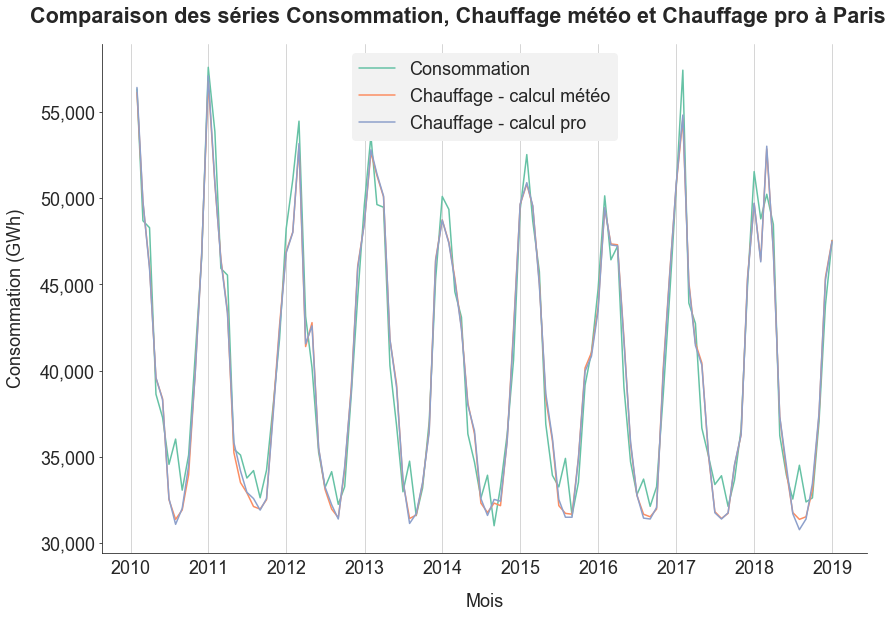

In [6]:
graph04 = sfg.MyGraph("Comparaison des séries Consommation, Chauffage météo et Chauffage pro à Paris")
graph04.add_plot(consommation.date, consommation.consommation, label="Consommation")
graph04.add_plot(consommation.date, consommation.chauffage_meteo_paris, label="Chauffage - calcul météo")
graph04.add_plot(consommation.date, consommation.chauffage_pro_paris, label="Chauffage - calcul pro", with_grid='x', legend=True)
graph04.set_axe('y', label="Consommation (GWh)", tick_dash=True, tick_labels_format=':,.0f')
graph04.set_axe('x', label="Mois")
fig, ax = graph04.fig, graph04.ax
plt.show()

Je constate que la saisonnalité des dju (et de la consommation) est annuelle, soit une fréquence de 12 avec des données mensuelles.

Je définis mes séries temporelles.

In [7]:
ts_conso = sft.TimeSerie(consommation, time_index='date', serie_values='consommation', model_type='add')
ts_dju_meteo = sft.TimeSerie(consommation, time_index='date', serie_values='chauffage_meteo_paris', model_type='add')
ts_dju_pro = sft.TimeSerie(consommation, time_index='date', serie_values='chauffage_pro_paris', model_type='add')

<a id='1_1'></a>

### 1.1. Correction basée sur le calcul météo des dju

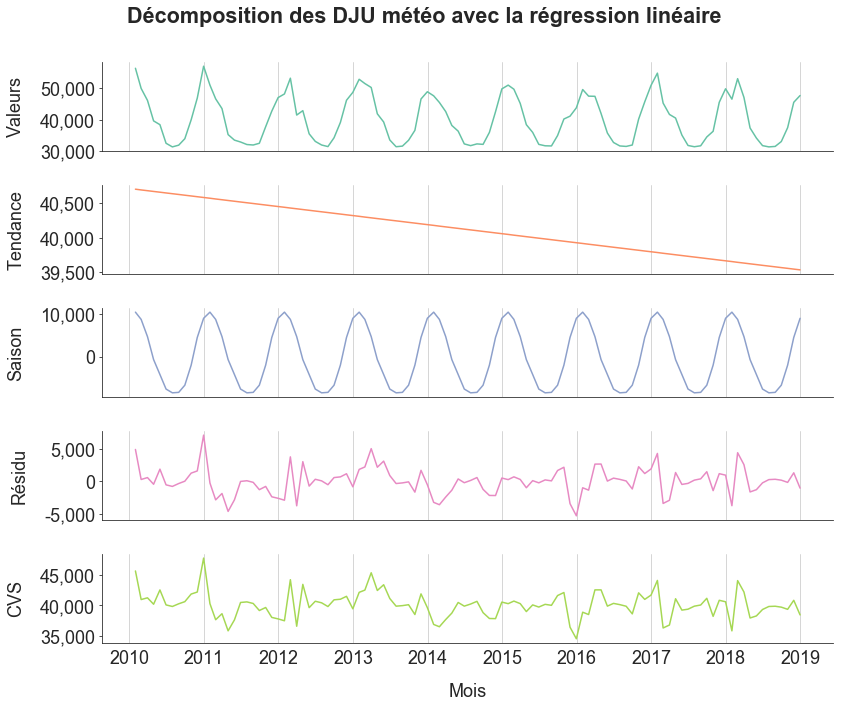

In [8]:
dju_meteo_decomp = ts_dju_meteo.decomp_lr_season(season_freq = 12)
meteo_a, meteo_b, meteo_c = ts_dju_meteo.decomp_lr_season(season_freq = 12, return_coefs=True)
fig, ax = ts_dju_meteo.tsplot(df_decomp=dju_meteo_decomp, title="Décomposition des DJU météo avec la régression linéaire", forced_color=-1)
ax[4].set_xlabel("Mois")
for g in range(5):
    ax[g].yaxis.set_major_formatter(plticker.StrMethodFormatter('{x:,.0f}'))
plt.savefig("M1_g1_decomp_dju.png")
plt.show()

On remarque une tendance baissière des dju, sans doute signe d'un réchauffement climatique...  
La série des dju peut être estimée par la régression linéaire  dju = tendance + coef de saisonnalité du mois

In [9]:
print("tendance dju_meteo = {}  +  {} * t".format(meteo_a,meteo_b))
print("coef de saisonnalité des mois = {}".format(meteo_c.values))

tendance dju_meteo = 40715.569270717875  +  -10.947223208979008 * t
coef de saisonnalité des mois = [10532.75077014  8823.38724017  4770.65169065  -638.48272194
 -4150.86425284 -7575.02471946 -8462.82958846 -8352.63366795
 -6665.4862237  -1945.73969532  4577.02483398  9087.24633473]


Pour corriger la consommation, il faut retirer la composante saisonnière lié au chauffage électrique. Je rajoute cette colonne dans mon dataframe consommation.

In [10]:
# deux choix ici
consommation["saison_meteo"] = dju_meteo_decomp.reset_index().seasonal
#consommation["saison_meteo"] = [meteo_c[mois-1] for mois in consommation.date.dt.month]  # ok car données commencent en janvier
consommation["conso_corrected_meteo"] = consommation.consommation - consommation.saison_meteo
consommation.head(6)

date  consommation  chauffage_meteo_paris  chauffage_pro_paris  \
0 2010-01-31         56342           56137.501556         56429.792637   
1 2010-02-28         48698           49785.584929         49822.682519   
2 2010-03-31         48294           46014.134431         45899.710887   
3 2010-04-30         38637           39562.969107         39602.309055   
4 2010-05-31         37284           38371.984739         38311.857860   
5 2010-06-30         34567           32516.311599         32582.254555   

   saison_meteo  conso_corrected_meteo  
0  10532.750770           45809.249230  
1   8823.387240           39874.612760  
2   4770.651691           43523.348309  
3   -638.482722           39275.482722  
4  -4150.864253           41434.864253  
5  -7575.024719           42142.024719

In [11]:
consommation.tail(6)

date  consommation  chauffage_meteo_paris  chauffage_pro_paris  \
102 2018-07-31         34514           31374.951580         30775.622882   
103 2018-08-31         32384           31523.824626         31395.039456   
104 2018-09-30         32620           33062.179434         33459.761367   
105 2018-10-31         37052           37429.122115         37537.587143   
106 2018-11-30         43814           45418.642248         45280.294313   
107 2018-12-31         47562           47552.489240         47499.870368   

     saison_meteo  conso_corrected_meteo  
102  -8462.829588           42976.829588  
103  -8352.633668           40736.633668  
104  -6665.486224           39285.486224  
105  -1945.739695           38997.739695  
106   4577.024834           39236.975166  
107   9087.246335           38474.753665

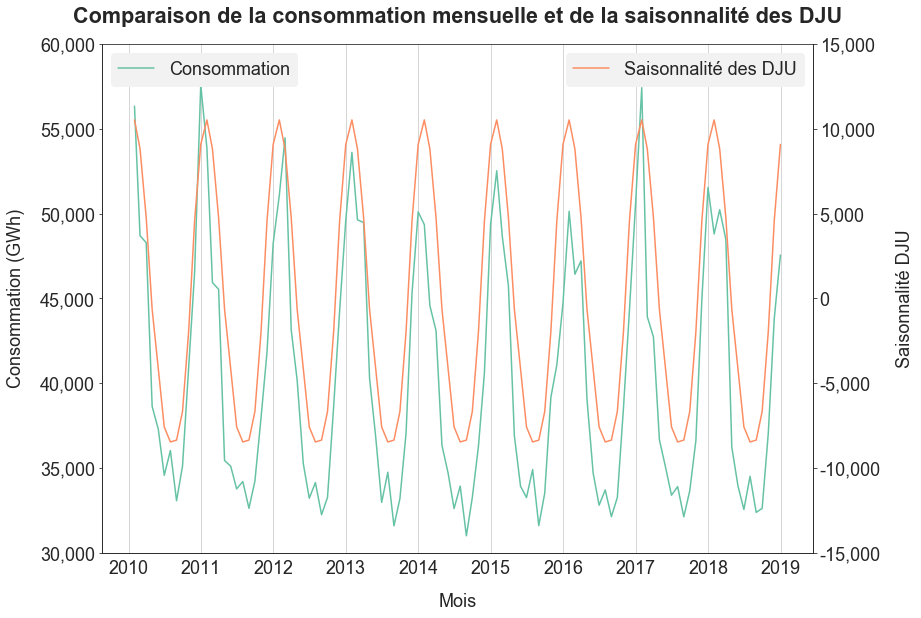

In [12]:
graph05a = sfg.MyGraph("Comparaison de la consommation mensuelle et de la saisonnalité des DJU")
graph05a.add_plot(consommation.date, consommation.consommation, label="Consommation", with_grid='x')
graph05a.add_plot(consommation.date, consommation.saison_meteo, label="Saisonnalité des DJU", color=graph05a.liste_couleurs[1], twinx=True)
graph05a.set_axe('y', label="Consommation (GWh)", tick_dash=True, tick_min=30000, tick_max=60000, tick_labels_format=':,.0f')
graph05a.set_axe('y', label="Saisonnalité DJU", tick_dash=True, tick_min=-15000, tick_max=15000, tick_labels_format=':,.0f', twinx=True, multi_index=2)
graph05a.set_axe('x', label="Mois")
graph05a.set_legend(loc="upper left", multi_index=1)
graph05a.set_legend(loc="upper right", multi_index=2)
fig, ax = graph05a.fig, graph05a.ax
plt.savefig("M1_g2_compar_conso_saisondju.png")
plt.show()

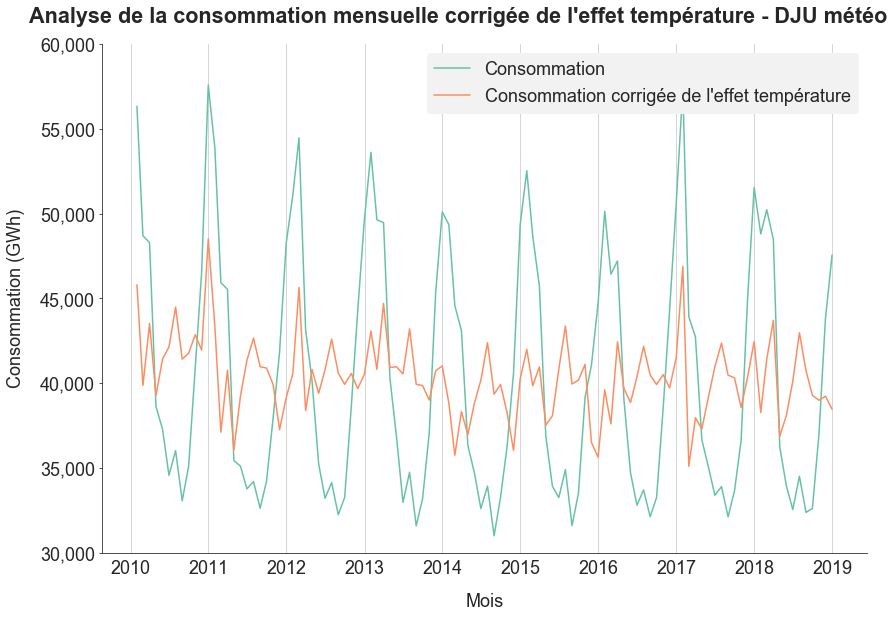

In [13]:
graph05b = sfg.MyGraph("Analyse de la consommation mensuelle corrigée de l'effet température - DJU météo")
graph05b.add_plot(consommation.date, consommation.consommation, label="Consommation")
graph05b.add_plot(consommation.date, consommation.conso_corrected_meteo, label="Consommation corrigée de l'effet température", with_grid='x', legend=True)
graph05b.set_axe('y', label="Consommation (GWh)", tick_dash=True, tick_min=30000, tick_max=60000, tick_labels_format=':,.0f')
graph05b.set_axe('x', label="Mois")
fig, ax = graph05b.fig, graph05b.ax
plt.savefig("M1_g3_conso_corrigee.png")
plt.show()

Je fais la même chose avec les dju pro pour voir l'impact du choix du type de calcul des dju.

<a id='1_2'></a>

### 1.2. Correction basée sur le calcul pro des dju

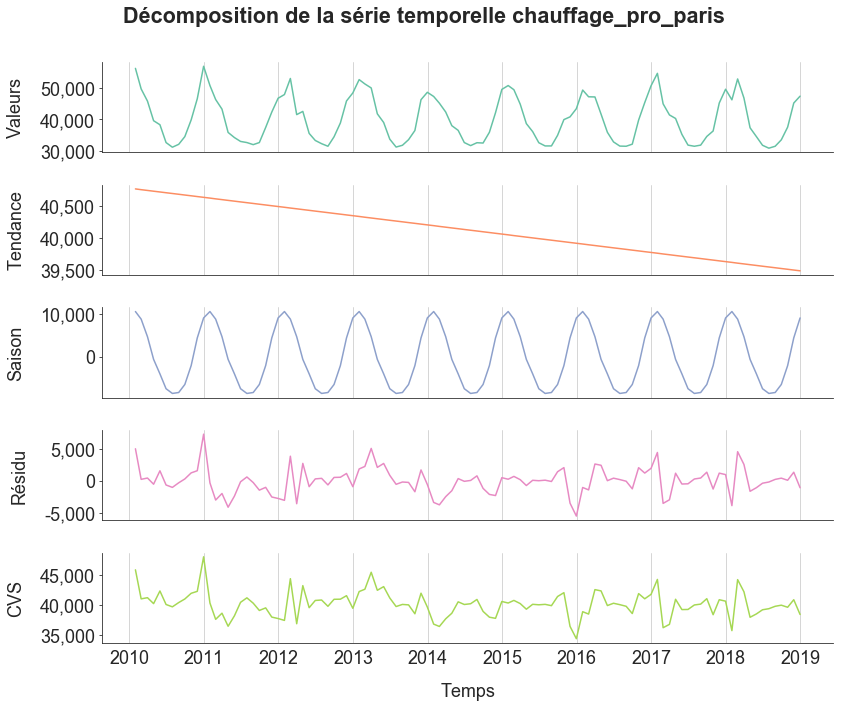

In [14]:
dju_pro_decomp = ts_dju_pro.decomp_lr_season(season_freq = 12)
fig, ax = ts_dju_pro.tsplot(df_decomp=dju_pro_decomp, forced_color=-1)
for g in range(5):
    ax[g].yaxis.set_major_formatter(plticker.StrMethodFormatter('{x:,.0f}'))
plt.show()

On remarque la même tendance baissière des dju.

In [15]:
# deux choix ici
consommation["saison_pro"] = dju_pro_decomp.reset_index().seasonal
consommation["conso_corrected_pro"] = consommation.consommation - consommation.saison_pro
consommation.head(6)

date  consommation  chauffage_meteo_paris  chauffage_pro_paris  \
0 2010-01-31         56342           56137.501556         56429.792637   
1 2010-02-28         48698           49785.584929         49822.682519   
2 2010-03-31         48294           46014.134431         45899.710887   
3 2010-04-30         38637           39562.969107         39602.309055   
4 2010-05-31         37284           38371.984739         38311.857860   
5 2010-06-30         34567           32516.311599         32582.254555   

   saison_meteo  conso_corrected_meteo    saison_pro  conso_corrected_pro  
0  10532.750770           45809.249230  10594.729771         45747.270229  
1   8823.387240           39874.612760   8817.360274         39880.639726  
2   4770.651691           43523.348309   4699.972610         43594.027390  
3   -638.482722           39275.482722   -610.365492         39247.365492  
4  -4150.864253           41434.864253  -4005.100487         41289.100487  
5  -7575.024719           42142.024719  -7485.865562         42052.865562

In [16]:
consommation.tail(6)

date  consommation  chauffage_meteo_paris  chauffage_pro_paris  \
102 2018-07-31         34514           31374.951580         30775.622882   
103 2018-08-31         32384           31523.824626         31395.039456   
104 2018-09-30         32620           33062.179434         33459.761367   
105 2018-10-31         37052           37429.122115         37537.587143   
106 2018-11-30         43814           45418.642248         45280.294313   
107 2018-12-31         47562           47552.489240         47499.870368   

     saison_meteo  conso_corrected_meteo   saison_pro  conso_corrected_pro  
102  -8462.829588           42976.829588 -8592.200438         43106.200438  
103  -8352.633668           40736.633668 -8373.672087         40757.672087  
104  -6665.486224           39285.486224 -6491.895529         39111.895529  
105  -1945.739695           38997.739695 -2069.363952         39121.363952  
106   4577.024834           39236.975166  4417.889537         39396.110463  
107   9087.246335           38474.753665  9098.511354         38463.488646

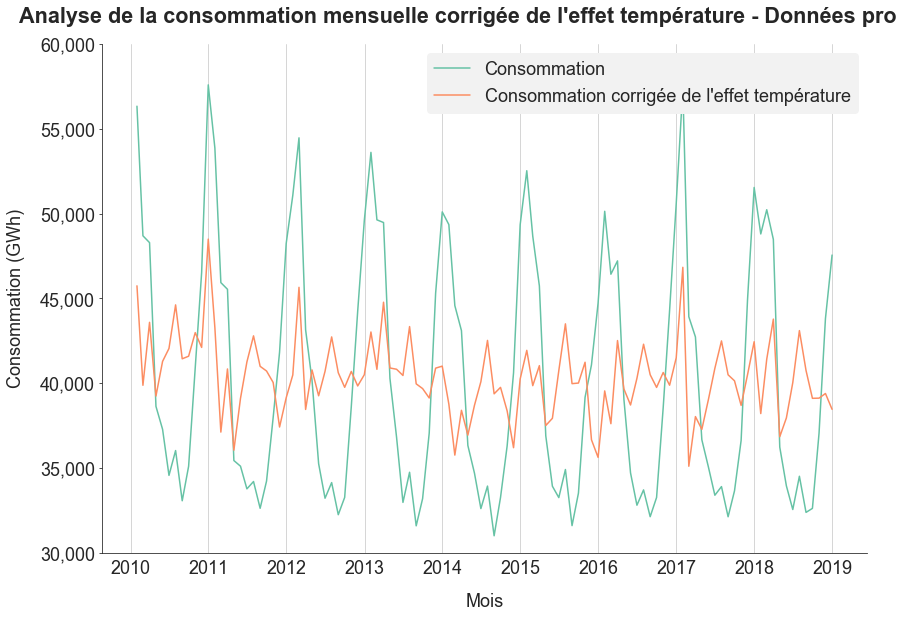

In [17]:
graph06 = sfg.MyGraph("Analyse de la consommation mensuelle corrigée de l'effet température - Données pro")
graph06.add_plot(consommation.date, consommation.consommation, label="Consommation")
graph06.add_plot(consommation.date, consommation.conso_corrected_pro, label="Consommation corrigée de l'effet température", with_grid='x', legend=True)
graph06.set_axe('y', label="Consommation (GWh)", tick_dash=True, tick_min=30000, tick_max=60000, tick_labels_format=':,.0f')
graph06.set_axe('x', label="Mois")
fig, ax = graph06.fig, graph06.ax
plt.show()

<a id='1_3'></a>

### 1.3. Comparaison des résultats obtenus

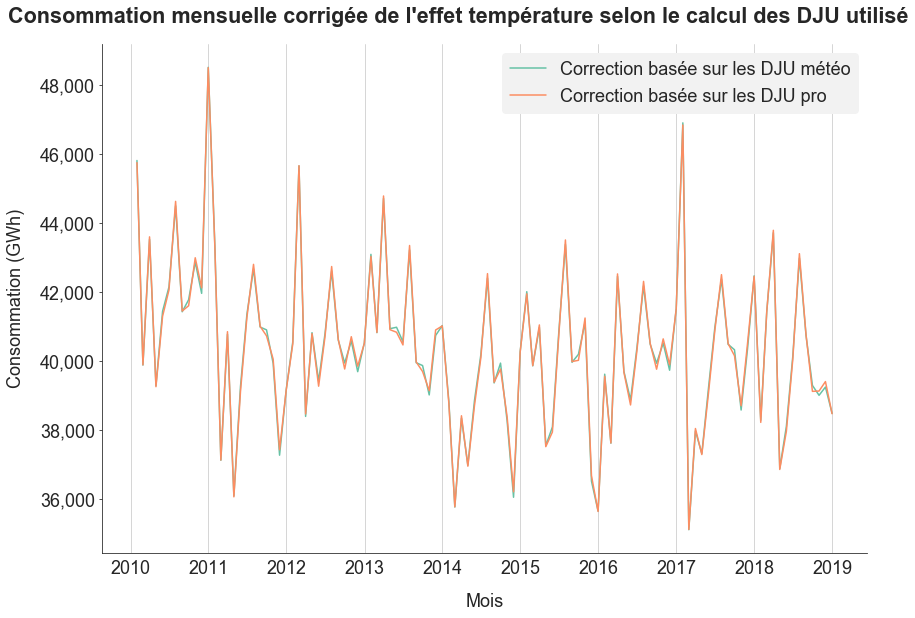

In [18]:
graph07 = sfg.MyGraph("Consommation mensuelle corrigée de l'effet température selon le calcul des DJU utilisé")
graph07.add_plot(consommation.date, consommation.conso_corrected_meteo, label="Correction basée sur les DJU météo")
graph07.add_plot(consommation.date, consommation.conso_corrected_pro, label="Correction basée sur les DJU pro", with_grid='x', legend=True)
graph07.set_axe('y', label="Consommation (GWh)", tick_dash=True, tick_labels_format=':,.0f')
graph07.set_axe('x', label="Mois")
fig, ax = graph07.fig, graph07.ax
plt.savefig("M1_g4_comparaison_meteo_pro.png")
plt.show()

Nous obtenons un consommation corrigée quasi-identique avec les deux types de données, au point qu'il est difficile de différencier les deux courbes. Nous pouvons choisir indifféremment les données dju calculées selon la modalité météo ou pro.  
**Je garde ma série corrigée sur le base des données dju_meteo.**

<a id='2_0'></a>

---
## <font color=blue>Mission 2 : Désaisonnaliser la consommation corrigée</font>

Pour cette mission, je calcule une série cvs à l'aide de la méthode des moyennes mobiles.  
J'ai à ma disposition différents outils :  
- la méthode automatique, à l'aide de la fonction tsa.seasonal_decompose de la librairie statsmodels ;  
- la méthode manuelle, qui reproduit manuellement le même raisonnement ;  
- l'algorithme x11, plus complexe.  

Je vais essayer les trois méthodes pour comparer leurs résultats.

### 2.1. Observation de la série à désaisonnaliser

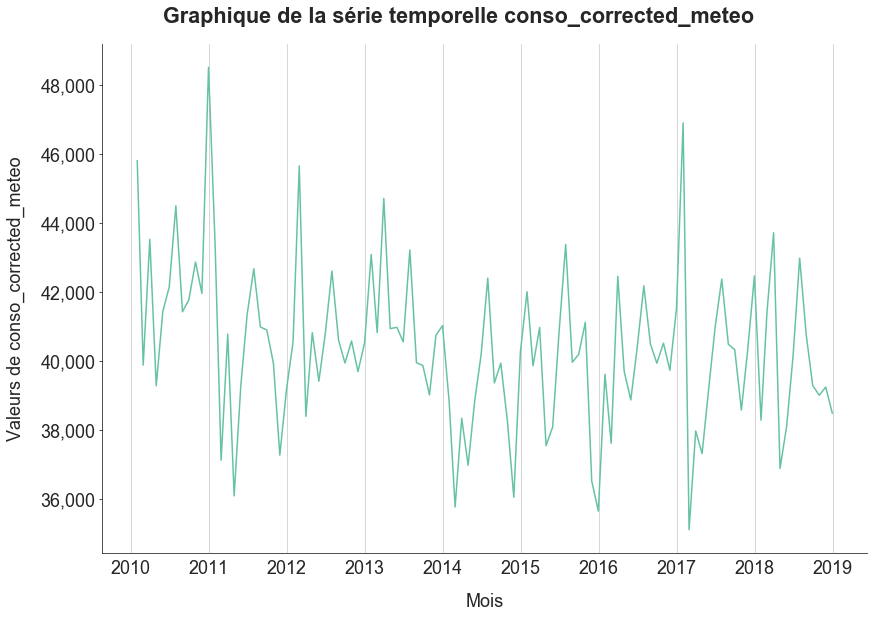

In [19]:
ts_conso_corrected = sft.TimeSerie(consommation, time_index="date", serie_values="conso_corrected_meteo", model_type='add')
fig, ax = ts_conso_corrected.tsplot(figsize=(12,8))
ax[0].yaxis.set_major_formatter(plticker.StrMethodFormatter('{x:,.0f}'))
ax[0].set_xlabel("Mois")
plt.savefig("M2_g1_serie_temporelle.png")
plt.show()

Aucune saisonnalité évidente ne se dégage de cette série temporelle. Je vais continuer à considérer une saisonnalité annuelle, ce qui donne une fréquence de 12 avec des données mensuelles.

<a id='2_2'></a>

### 2.2. Désaisonnalisation automatique

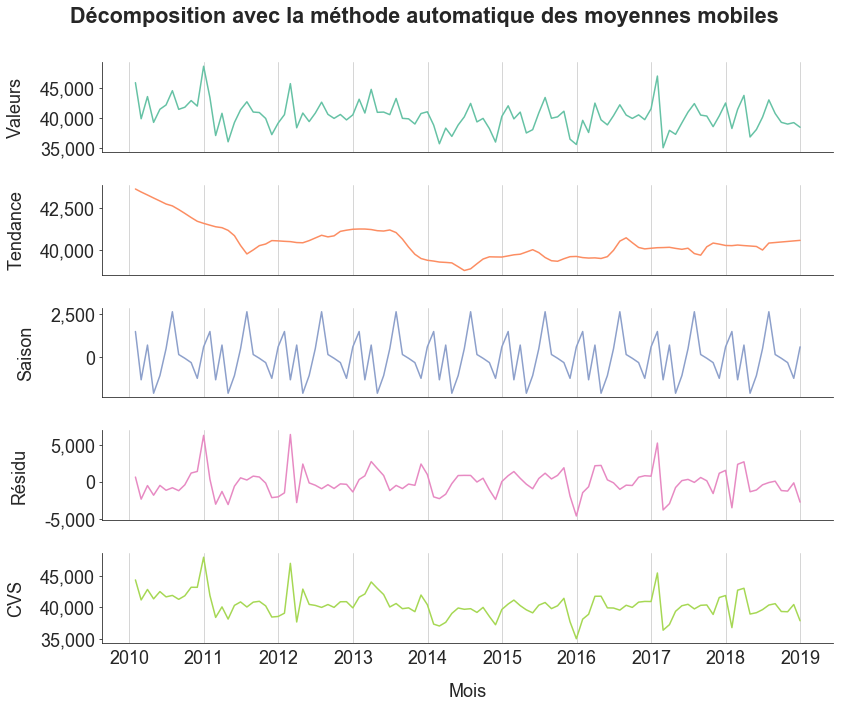

In [20]:
conso_decomp = ts_conso_corrected.decomp_ma_auto(season_freq = 12)
fig, ax = ts_conso_corrected.tsplot(df_decomp=conso_decomp, title="Décomposition avec la méthode automatique des moyennes mobiles", forced_color=-1)
for g in range(5):
    ax[g].yaxis.set_major_formatter(plticker.StrMethodFormatter('{x:,.0f}'))
ax[4].set_xlabel("Mois")
plt.savefig("M2_g2_ma_auto_decomp.png")
plt.show()

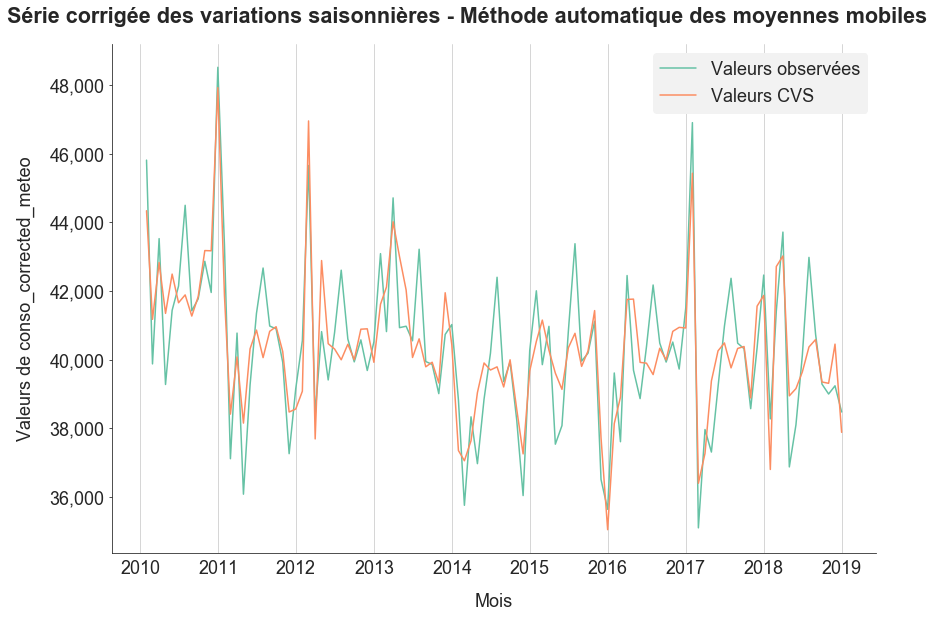

In [21]:
fig, ax = ts_conso_corrected.plot_cvs(conso_decomp, title="Série corrigée des variations saisonnières - Méthode automatique des moyennes mobiles")
ax[0].yaxis.set_major_formatter(plticker.StrMethodFormatter('{x:,.0f}'))
ax[0].set_xlabel("Mois")
plt.savefig("M2_g3_ma_auto_cvs.png")
plt.show()

<a id='2_3'></a>

### 2.3. Désaisonnalisation manuelle

Ci-dessous, je fais la même décomposition manuellement. Afin d'avoir des données pour les premières et dernières valeurs de la moyenne mobile centrée 2x12, j'applique un calcul partiel avec les données disponibles en début et en fin de série.

In [22]:
manual_detrend = consommation[["date","conso_corrected_meteo"]].copy()
manual_detrend.head()

date  conso_corrected_meteo
0 2010-01-31           45809.249230
1 2010-02-28           39874.612760
2 2010-03-31           43523.348309
3 2010-04-30           39275.482722
4 2010-05-31           41434.864253

In [23]:
manual_detrend["trend"] = ts_conso_corrected._TimeSerie__get_ma2(2,12,manual_detrend.conso_corrected_meteo, extrapol=True)
manual_detrend["reste"] = manual_detrend.conso_corrected_meteo - manual_detrend.trend
manual_detrend["seasonal"] = [manual_detrend[manual_detrend.date.dt.month==mois].reste.mean() for mois in manual_detrend.date.dt.month]
manual_detrend["resid"] = manual_detrend.reste - manual_detrend.seasonal
manual_detrend["cvs"] = manual_detrend.conso_corrected_meteo - manual_detrend.seasonal
manual_detrend.head(10)

date  conso_corrected_meteo         trend        reste     seasonal  \
0 2010-01-31           45809.249230  42364.773083  3444.476147  1522.667961   
1 2010-02-28           39874.612760  42305.826870 -2431.214110 -1262.557818   
2 2010-03-31           43523.348309  42220.358743  1302.989566   720.567708   
3 2010-04-30           39275.482722  42227.331974 -2951.849252 -2066.007868   
4 2010-05-31           41434.864253  42246.924755  -812.060503 -1073.432942   
5 2010-06-30           42142.024719  42494.677864  -352.653144   421.032735   
6 2010-07-31           44493.829588  42653.458333  1840.371255  2570.158288   
7 2010-08-31           41421.633668  42435.541667 -1013.907999   118.198638   
8 2010-09-30           41769.486224  42205.875000  -436.388776   -62.680529   
9 2010-10-31           42863.739695  41958.125000   905.614695  -301.836756   

         resid           cvs  
0  1921.808185  44286.581268  
1 -1168.656292  41137.170578  
2   582.421858  42802.780601  
3  -885.841384  41341.490590  
4   261.372440  42508.297195  
5  -773.685879  41720.991985  
6  -729.787033  41923.671300  
7 -1132.106637  41303.435030  
8  -373.708247  41832.166753  
9  1207.451451  43165.576451

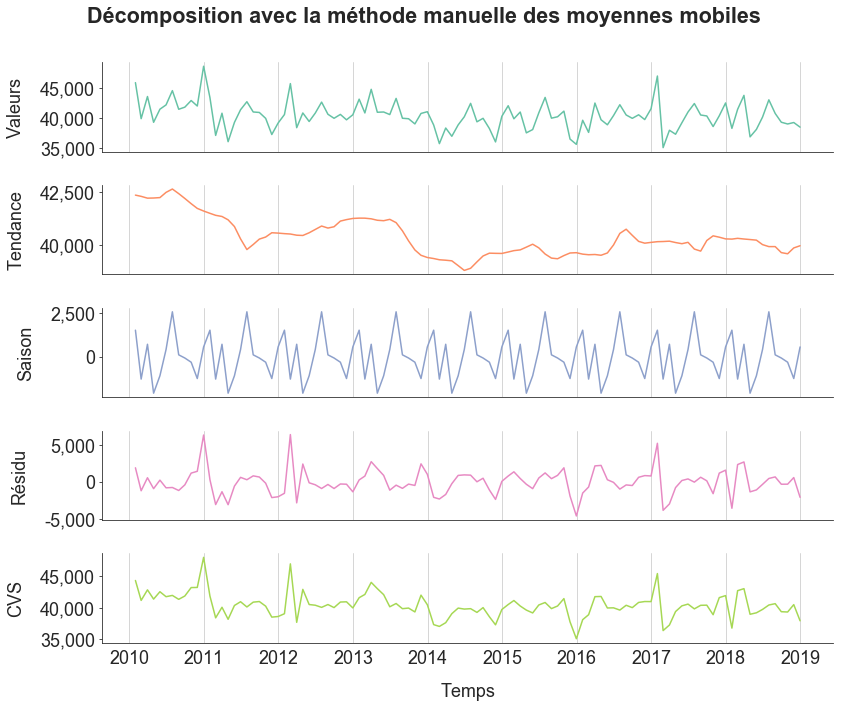

In [24]:
manual_decomp = manual_detrend[["date","conso_corrected_meteo","trend","seasonal","resid","cvs"]].set_index("date")
fig, ax = ts_conso_corrected.tsplot(df_decomp=manual_decomp, title="Décomposition avec la méthode manuelle des moyennes mobiles", forced_color=-1)
for g in range(5):
    ax[g].yaxis.set_major_formatter(plticker.StrMethodFormatter('{x:,.0f}'))
plt.show()

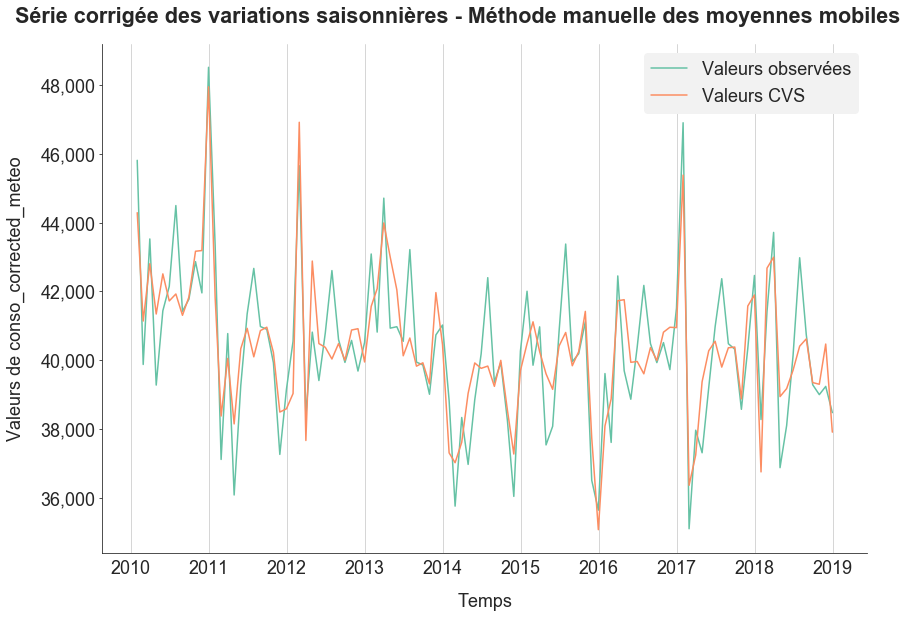

In [25]:
fig, ax = ts_conso_corrected.plot_cvs(manual_decomp, title="Série corrigée des variations saisonnières - Méthode manuelle des moyennes mobiles")
ax[0].yaxis.set_major_formatter(plticker.StrMethodFormatter('{x:,.0f}'))
plt.show()

Les résultats sont similaires, au détail près des estimations des premières et dernières valeurs de la tendance qui sont calculées différemment. Les différences restent minimes.

<a id='2_4'></a>

### 2.4. Désaisonnalisation avec l'algorithme x11

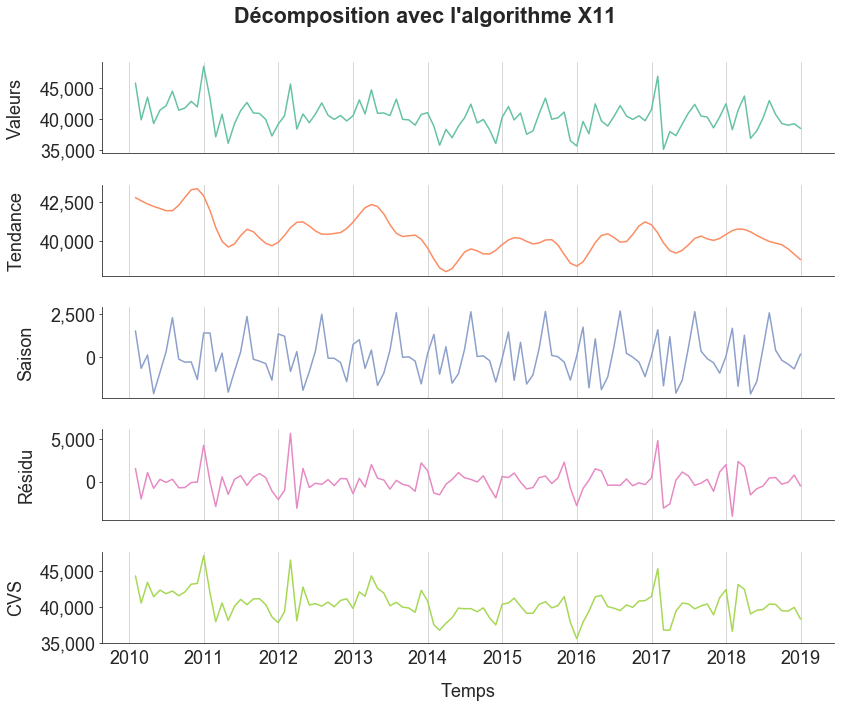

In [26]:
x11_decomp = ts_conso_corrected.decomp_ma_x11()
fig, ax = ts_conso_corrected.tsplot(df_decomp = x11_decomp, title="Décomposition avec l'algorithme X11", forced_color=-1)
for g in range(5):
    ax[g].yaxis.set_major_formatter(plticker.StrMethodFormatter('{x:,.0f}'))
plt.show()

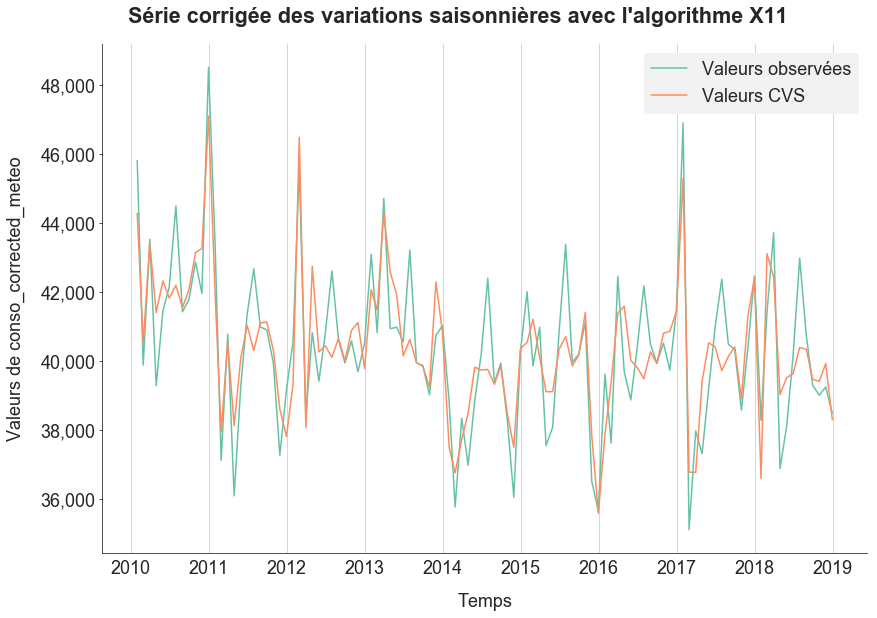

In [27]:
fig, ax = ts_conso_corrected.plot_cvs(x11_decomp, title="Série corrigée des variations saisonnières avec l'algorithme X11")
ax[0].yaxis.set_major_formatter(plticker.StrMethodFormatter('{x:,.0f}'))
plt.show()

<a id='2_5'></a>

### 2.5. Comparaison des courbes cvs obtenues avec les 3 méthodes

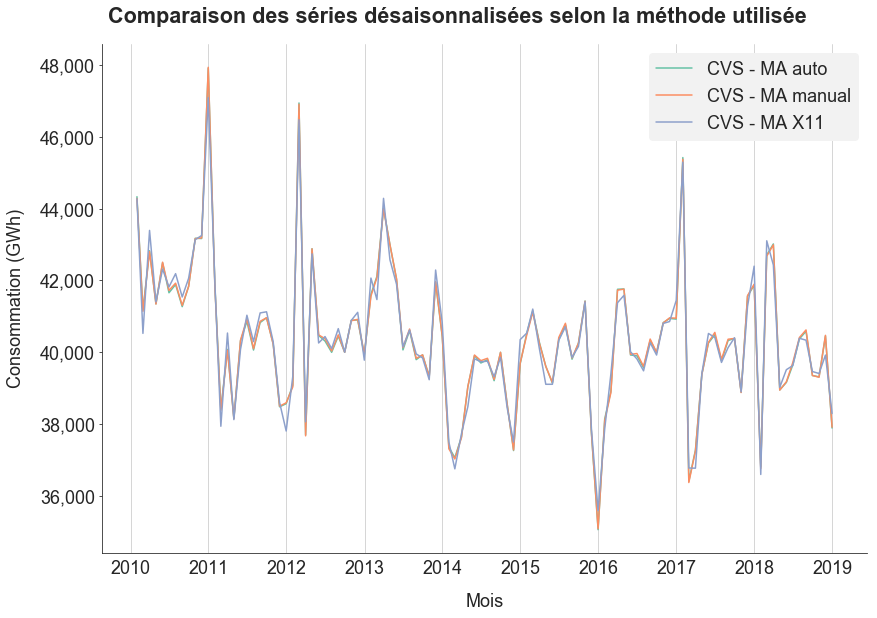

In [28]:
graph08 = sfg.MyGraph("Comparaison des séries désaisonnalisées selon la méthode utilisée")
graph08.add_plot(conso_decomp.index, conso_decomp.cvs, label="CVS - MA auto")
graph08.add_plot(manual_decomp.index, manual_decomp.cvs, label="CVS - MA manual")
graph08.add_plot(x11_decomp.index, x11_decomp.cvs, label="CVS - MA X11", with_grid='x', legend=True)
graph08.set_axe('y', label="Consommation (GWh)", tick_dash=True, tick_labels_format=':,.0f')
graph08.set_axe('x', label="Mois")
fig, ax = graph08.fig, graph08.ax
plt.savefig("M2_g4_ma_comparaison.png")
plt.show()

Les trois courbes désaisonnalisées sont très similaires. Les deux courbes MA auto et MA manual se confondent la plupart du temps.
La coubre MA X11 est très proche. On remarque qu'elle permet souvent de limiter un peu les valeurs extrêmes locales.

L'apport de la désaisonnalisation ne paraît pas évident lorsque l'on compare la courbe de la consommation corrigée et sa version cvs.

<a id='3_0'></a>

---
## <font color=blue>Mission 3 : Prévoir la consommation sur un an</font>

### 3.1. Prévision par lissage exponentiel

Nous utilisons la méthode de Holt Winters qui permet de prendre en compte une tendance et une saisonnalité des données.

Pour rappel, nous nous basons sur la consommation corrigée de l'effet température, illustrée ci-dessous.

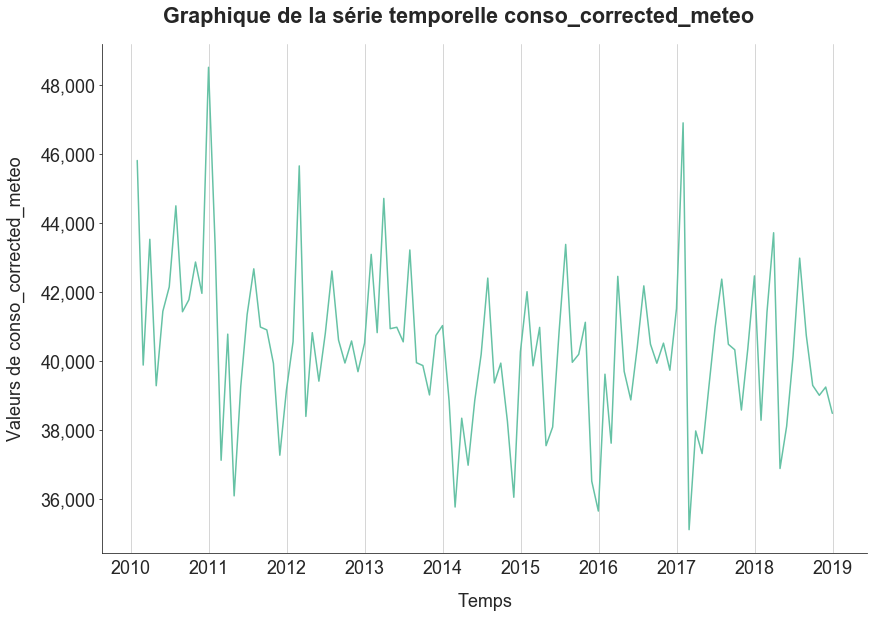

In [29]:
fig, ax = ts_conso_corrected.tsplot(figsize=(12,8))
ax[0].yaxis.set_major_formatter(plticker.StrMethodFormatter('{x:,.0f}'))
plt.show()

Pour rappel, voici les dernières valeurs de la série.

In [30]:
ts_conso_corrected.df[["date","conso_corrected_meteo"]].tail()

date  conso_corrected_meteo
103 2018-08-31           40736.633668
104 2018-09-30           39285.486224
105 2018-10-31           38997.739695
106 2018-11-30           39236.975166
107 2018-12-31           38474.753665

In [31]:
prevision_lissage_exponentiel = ts_conso_corrected.forecast_lissage_exp(data_freq='M', trend_type='add', season_type='add', season_freq=12, nb_forecast=12)
prevision_lissage_exponentiel

t      forecast
0  2019-01-31  41593.341646
1  2019-02-28  38975.235215
2  2019-03-31  40420.747909
3  2019-04-30  37775.107451
4  2019-05-31  38926.646275
5  2019-06-30  40312.469418
6  2019-07-31  42274.199130
7  2019-08-31  39840.510990
8  2019-09-30  39684.001386
9  2019-10-31  39470.794903
10 2019-11-30  38310.952917
11 2019-12-31  40475.522607

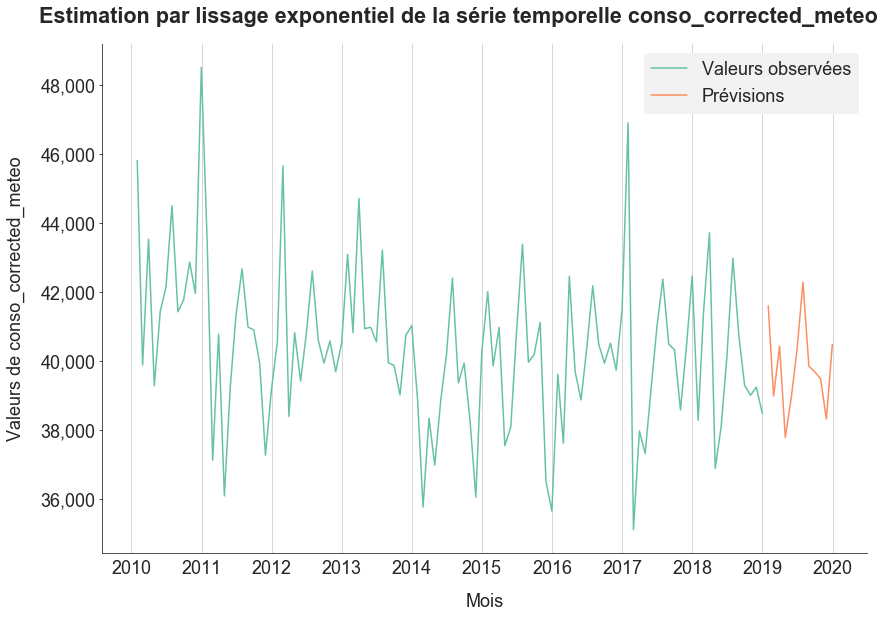

In [32]:
fig, ax = ts_conso_corrected.plot_forecast(prevision_lissage_exponentiel)
ax[0].yaxis.set_major_formatter(plticker.StrMethodFormatter('{x:,.0f}'))
ax[0].set_xlabel("Mois")
plt.savefig("M3_g1_lissage_exponentiel.png")
plt.show()

<a id='3_2'></a>

### 3.2. Prévision par une modélisation SARIMA

#### 3.2.1. Première analyse de la série temporelle

C:\Anaconda3\envs\Jupyter\lib\site-packages\statsmodels\tsa\statespace\representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]


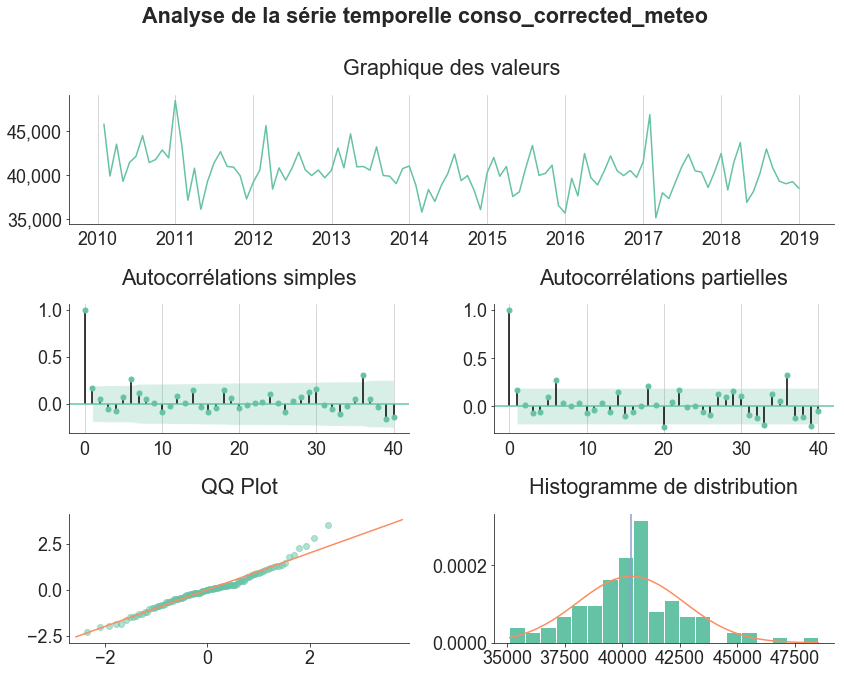

In [33]:
sari = sft.Sarimax(consommation, time_index="date", serie_values="conso_corrected_meteo")
fig, ax = sari.check_rawserie()
ax[0].yaxis.set_major_formatter(plticker.StrMethodFormatter('{x:,.0f}'))
plt.savefig("M3_g2_sarima_serie_temporelle.png")
plt.show()

Le graphique des valeurs laisse penser que le processus est stationnaire en l'état. Les graphiques des autocorrélations confirment cette impression.  
La distribution des valeurs de conso_corrected_meteo est assez proche d'une loi normale.  
J'analyse les autocorrélations pour vérifier qu'il n'est pas nécessaire de différencier la série temporelle.

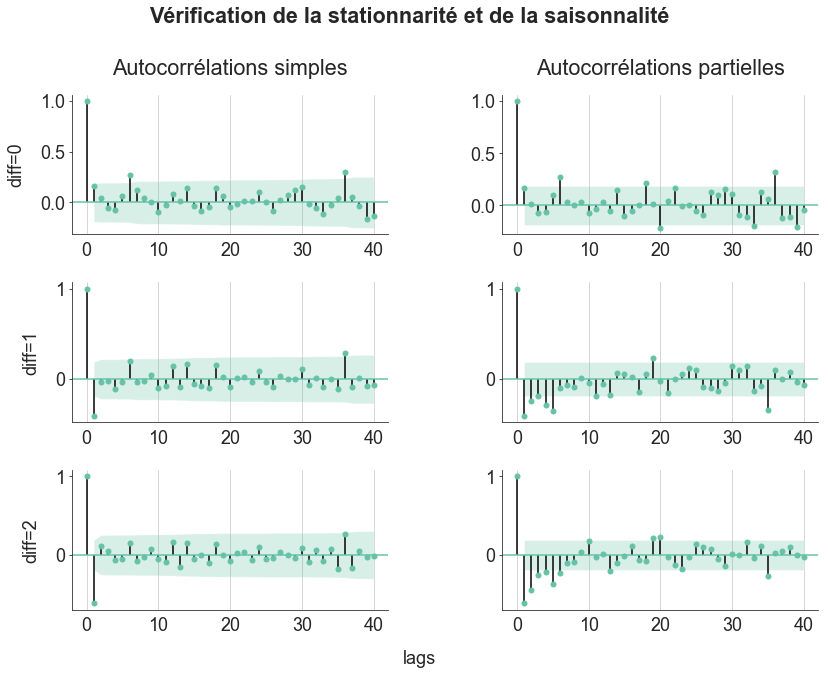

In [34]:
fig, ax = sari.check_autocorrelations()
plt.savefig("M3_g3_sarima_autocorrelations_0.png")
plt.show()

Le graphique des autocorrélogrammes simples et partiels, avec différents niveaux de différenciation, confirme qu'il n'est pas nécessaire de différencier la série temporelle. En effet, l'autocorrélation simple de rang 1 est très négative avec une différenciation simple ou double : cela traduit une sur-différenciation à ces niveaux.  
Cela confirme que notre série temporelle est stationnaire en son état initial.

L'analyse de l'autocorrélation partielle montre que le processus AR peut être testé avec un ordre de 0 (pas de processus AR) ou de 1.  
L'analyse de l'autocorrélation simple, aboutit aux mêmes conclusions pour le processus MA (ordre de 0 ou de 1).  
Il est également intéressant d'intégrer 6 périodes car la sixième autocorrélation est marquée, qu'elle soit simple ou partielle.

Aucune saisonnalité ne se dégage de manière évidente sur les autocorrélogrammes. Je remarque sur l'autocorrélogramme simple que les autocorrélations de rang 24 et 36 ressortent par rapport aux autres. Par contre pas celle du douzième rang. Une étude attentive mène à penser qu'il peut y avoir une fréquence de 6 périodes (semestrielle) ou de 12 périodes (annuelle).  
Je regarde ces mêmes autocorrélogrammes avec une saisonnalité de fréquence 6 puis de fréquence 12.

C:\Anaconda3\envs\Jupyter\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


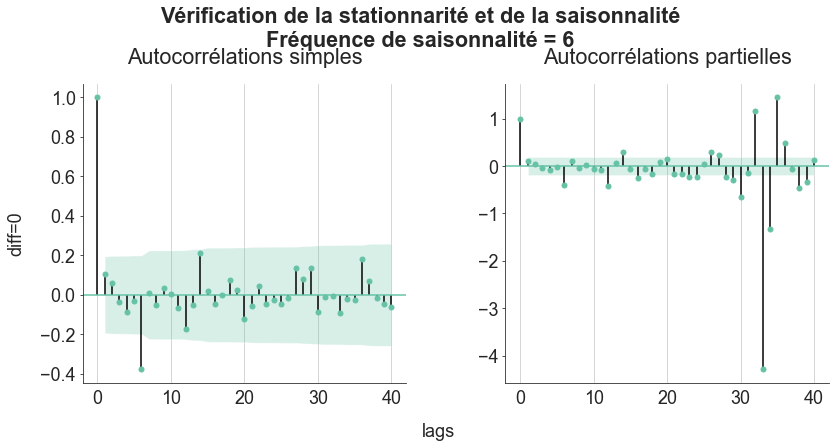

In [35]:
fig, ax = sari.check_autocorrelations(season_freq=6, max_diff=0)
#plt.savefig("M3_g4a_sarima_autocorrelations_6.png")
plt.show()

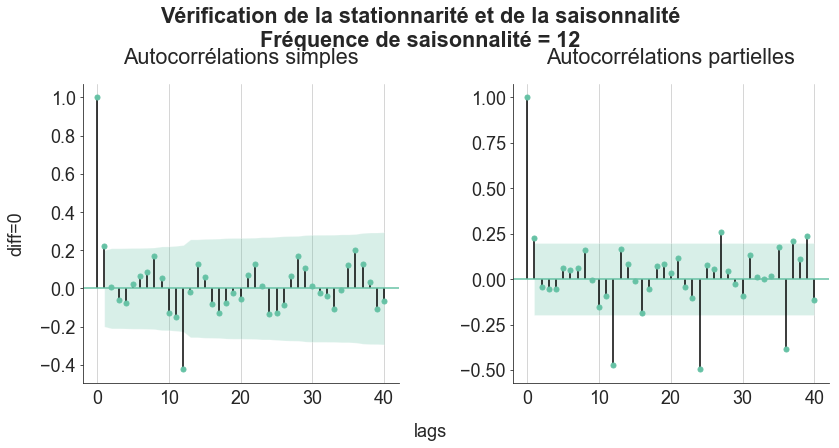

In [36]:
fig, ax = sari.check_autocorrelations(season_freq=12, max_diff=0)
#plt.savefig("M3_g5b_sarima_autocorrelations_12.png")
plt.show()

Avec une saisonnalité de 6 mois, l'autocorrélation partielle de rang 1 est tout de suite nulle. De plus, les autocorrélations partielles autour du retard 33 affichent des valeurs fortement négatives et positives. Aucun processus AR ne semble satisfaisant avec une saisonnalité de 6. Un processus MA d'ordre 1 ou 2 peut être envisagé.  
J'ai tendance à privilégier une fréquence de saisonnalité de 12, car les autocorrélogrammes sont plus équilibrés avec cette fréquence, avec laquelle on peut envisager un processus AR d'ordre 1 et un processus MA d'ordre 1.  
La saisonnalité n'étant pas évidente, je testerai également sans saisonnalité et avec une saisonnalité de 0 (ce qui revient à un double ARIMA sans saisonnalité).

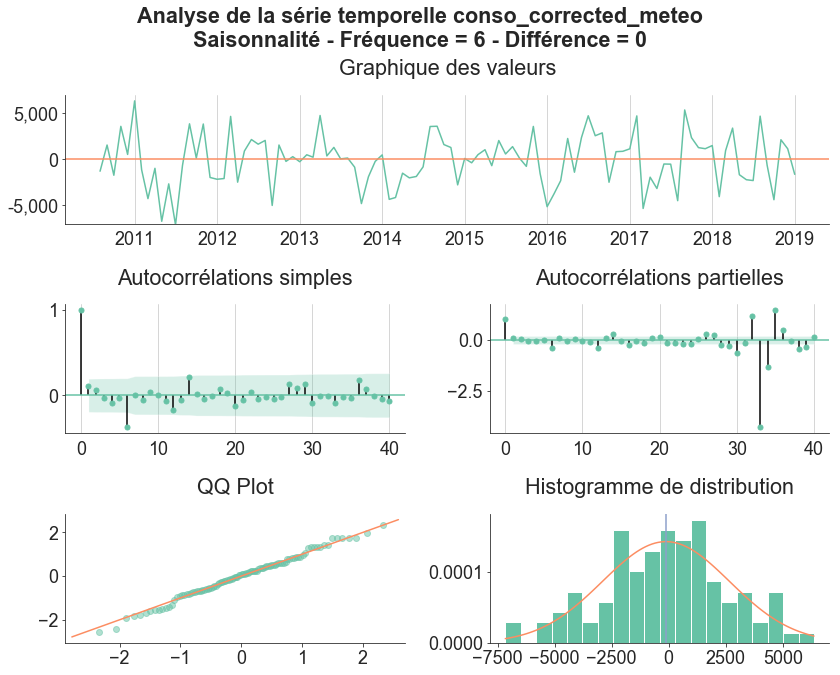

In [37]:
fig, ax = sari.check_season(season_freq=6, season_diff=0)
ax[0].yaxis.set_major_formatter(plticker.StrMethodFormatter('{x:,.0f}'))
plt.savefig("M3_g4_sarima_season_6.png")
plt.show()

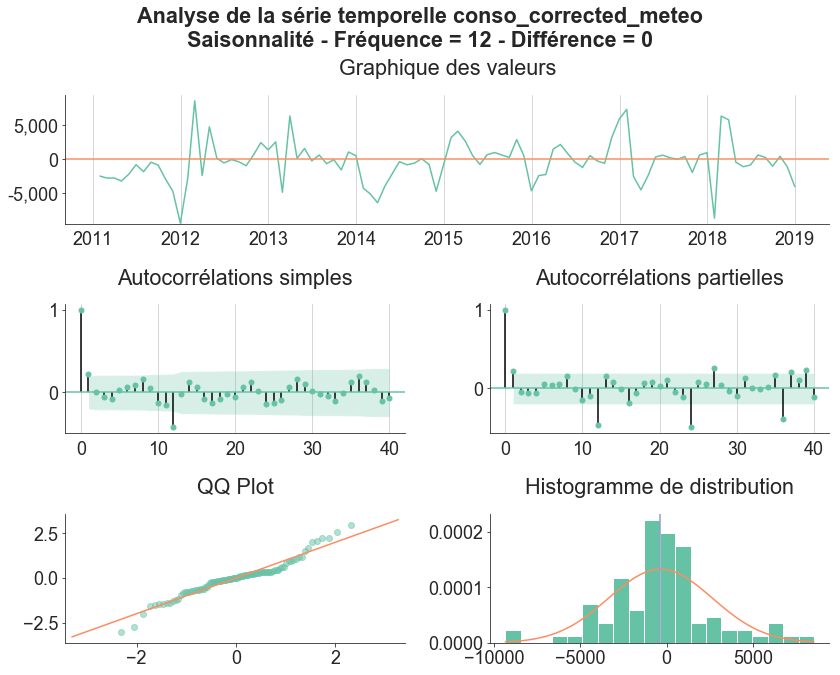

In [38]:
fig, ax = sari.check_season(season_freq=12, season_diff=0)
ax[0].yaxis.set_major_formatter(plticker.StrMethodFormatter('{x:,.0f}'))
plt.savefig("M3_g5_sarima_season_12.png")
plt.show()

<a id='3_2_2'></a>

### 3.2.2. Test d'un modèle ARIMA sans saisonnalité

Comme l'existence d'une saisonnalité n'est pas évidente, je commence par chercher un modèle ARIMA sans saisonnalité. Comme on ne différencie pas la série, notre étude porte en fait sur un modèle ARMA.  
Je cherche parmi tous les modèles ARMA avec une période comprise entre 0 et 6 pour le processus AR et pour le processus MA.

In [39]:
best_order = sari.get_arima_best_models(d=[0])

Les trois meilleurs modèles sont :
AIC = 1991.91  |  order = (1, 0, 1)
AIC = 2019.03  |  order = (3, 0, 0)
AIC = 2023.40  |  order = (2, 0, 0)


La détection automatique du meilleur modèle, qui se base sur le score AIC et qui vérifie la significativité des paramètres, confirme notre analyse visuelle des corrélogrammes en sélectionnant un modèle ARIMA(1,0,1).  
J'analyse les résultats de ce modèle.

In [40]:
sari.set_season_coef(0, 0, 0, -1, with_calculation=False)  # désactive la partie saisonnière
sari.set_arima_coef(1, 0, 1)
sari.check_results()

                             Statespace Model Results                            
Dep. Variable:     conso_corrected_meteo   No. Observations:                  108
Model:                  SARIMAX(1, 0, 1)   Log Likelihood                -992.955
Date:                   Wed, 29 Jan 2020   AIC                           1991.910
Time:                           23:17:17   BIC                           1999.956
Sample:                                0   HQIC                          1995.172
                                   - 108                                         
Covariance Type:                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000   5.38e-05   1.86e+04      0.000       1.000       1.000
ma.L1         -0.9281      0.042    -22.290      0.000      -1.010      -0.847
sigma2      5.276e+06    3.9

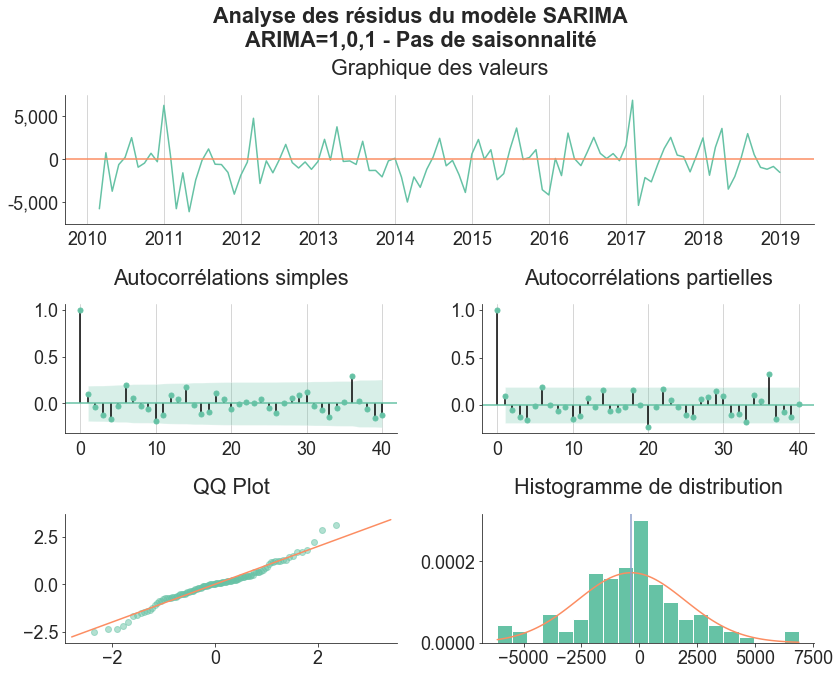

In [41]:
fig, ax = sari.check_residuals()
ax[0].yaxis.set_major_formatter(plticker.StrMethodFormatter('{x:,.0f}'))
#plt.savefig("M3_g6_arima_101.png")
plt.show()

L'analyse visuelle des résidus montre une variance assez constante dans le temps, ce qui est confirmé par le test d'homoscédasticité qui accepte l'hypothèse nulle de la constance de la variance.  
Les résidus ont une distribution proche de la loi normale. Les tests de normalité ont des conclusions plus mitigées : le test de Jarque-Bera conclut à la normalité des résidus, au contraire du test de Shapiro.  
Enfin, concernant la blancheur des résidus, le test Ljung-Box rejette la blancheur globale des résidus. Le test de Portmanteau nuance cette conclusion en ne rejetant la blancheur des résidus que pour les retards conséquents (lag=36).  
Ces tests sur les hypothèses de normalité et de blancheur des résidus ne sont donc pas totalement satisfaisants.

Je regarde également les deux autres modèles qui ressortent du processus de détection automatique : AR(3) et AR(2).

In [42]:
sari.set_arima_coef(3, 0, 0)
sari.check_results()

                             Statespace Model Results                            
Dep. Variable:     conso_corrected_meteo   No. Observations:                  108
Model:                  SARIMAX(3, 0, 0)   Log Likelihood               -1005.517
Date:                   Wed, 29 Jan 2020   AIC                           2019.033
Time:                           23:17:18   BIC                           2029.762
Sample:                                0   HQIC                          2023.383
                                   - 108                                         
Covariance Type:                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4835      0.087      5.576      0.000       0.314       0.653
ar.L2          0.2727      0.094      2.897      0.004       0.088       0.457
ar.L3          0.2427      0

In [43]:
sari.set_arima_coef(2, 0, 0)
sari.check_results()

                             Statespace Model Results                            
Dep. Variable:     conso_corrected_meteo   No. Observations:                  108
Model:                  SARIMAX(2, 0, 0)   Log Likelihood               -1008.702
Date:                   Wed, 29 Jan 2020   AIC                           2023.403
Time:                           23:17:19   BIC                           2031.450
Sample:                                0   HQIC                          2026.666
                                   - 108                                         
Covariance Type:                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5808      0.076      7.630      0.000       0.432       0.730
ar.L2          0.4177      0.077      5.394      0.000       0.266       0.570
sigma2      6.981e+06   1.56

Ces deux modèles ne respectent pas les hypothèses de base de blancheur et de normalité des résidus.

Le modèle ARIMA (1,0,1) est supérieur.
Je cherche maintenant à ajouter une saisonnalité de fréquence 0, 6 ou 12.

<a id='3_2_3'></a>

### 3.2.3. Test d'un modèle SARIMA

Mes analyses précédentes me permettent de réduire le champs des modèles analysés aux ordres 0 et 1, que ce soit pour la partie AR ou MA. Pour la partie MA, j'ajoute l'ordre 2 (cf analyse de la saisonnalité de fréquence 6).  
Les fréquences de saisonnalité étudiées sont 0 (ce qui revient à analyser un double modèle ARMA), 6 (saisonnalité semestrielle) et 12 (saisonnalité annuelle).

In [44]:
best_order = sari.get_sarima_best_models(p=[0,1],d=[0],q=[0,1,2],season_freq=[0,6,12])

Les trois meilleurs modèles sont :
AIC = 1982.34  |  order ARIMA= (1, 0, 1)  |  order Season= (1, 0, 1, 12)
AIC = 1987.99  |  order ARIMA= (1, 0, 1)  |  order Season= (0, 0, 1, 6)
AIC = 1991.91  |  order ARIMA= (0, 0, 0)  |  order Season= (1, 0, 1, 0)


La détection automatique aboutit à un modèle SARIMA (1,0,1)(1,0,1,12) assez cohérent avec nos analyses des corrélogrammes.

In [45]:
sari.set_arima_coef(1, 0, 1, with_calculation=False)
sari.set_season_coef(1,0,1,12)
sari.check_results()

                                 Statespace Model Results                                 
Dep. Variable:              conso_corrected_meteo   No. Observations:                  108
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood                -986.169
Date:                            Wed, 29 Jan 2020   AIC                           1982.338
Time:                                    23:17:36   BIC                           1995.749
Sample:                                         0   HQIC                          1987.776
                                            - 108                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9993      0.001    967.617      0.000       0.997       1.001
ma.L1         -0.9151      0.040   

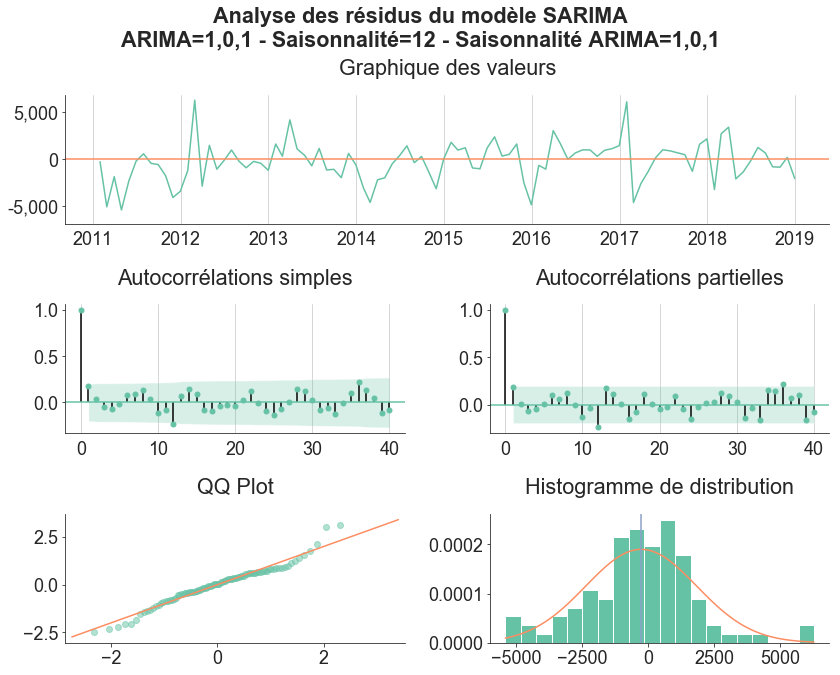

In [46]:
fig, ax = sari.check_residuals()
ax[0].yaxis.set_major_formatter(plticker.StrMethodFormatter('{x:,.0f}'))
plt.savefig("M3_g7_sarima_101_101_12.png")
plt.show()

En ajoutant une saisonnalité de fréquence 12 avec des processus AR de période 1 et MA de période 1, nous obtenons un modèle dont les résidus sont bien plus satisfaisants.  
En effet, tous les tests de vérification des hypothèses sur les résidus sont désormais validés : les tests de blancheur, global et de Portmanteau, sont validés. Le test de normalité est validé par le test de Jarque Berra. La p-value est meilleure pour le test de Shapiro, qui rejette toujours l'hypothèse de normalité au seuil de 5% mais l'accepte désormais au seuil de 2%. Enfin, l'homoscédasticité des résidus est acceptée.

J'évalue ce même modèle en l'entraînant sur les données de 2010 à fin 2017, puis en le testant sur l'année 2018.
Ma période de test est donc d'une année sur 9 années de données disponibles.

Longueur de la période d'entraînement : 96
Longueur de la période de test : 12

Vérification du modèle sur la période d'entraînement


C:\Anaconda3\envs\Jupyter\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                 Statespace Model Results                                 
Dep. Variable:              conso_corrected_meteo   No. Observations:                   96
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood                -880.720
Date:                            Wed, 29 Jan 2020   AIC                           1771.441
Time:                                    23:17:39   BIC                           1784.263
Sample:                                         0   HQIC                          1776.624
                                             - 96                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000   9.11e-06    1.1e+05      0.000       1.000       1.000
ma.L1         -0.9470      0.035   

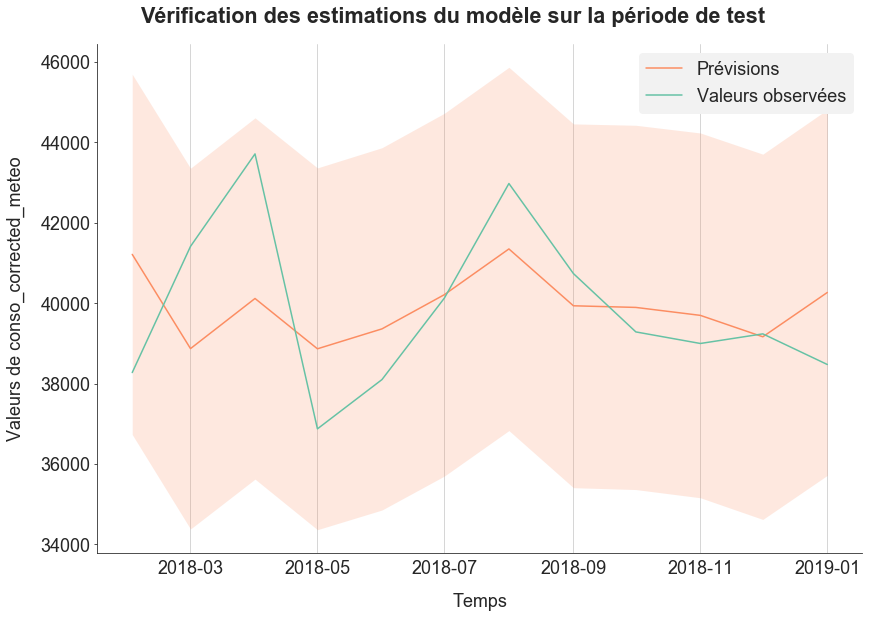

In [47]:
forecast_eval = sari.evaluate_model(data_freq='MS', test_percent=1/9, return_forecast=True)

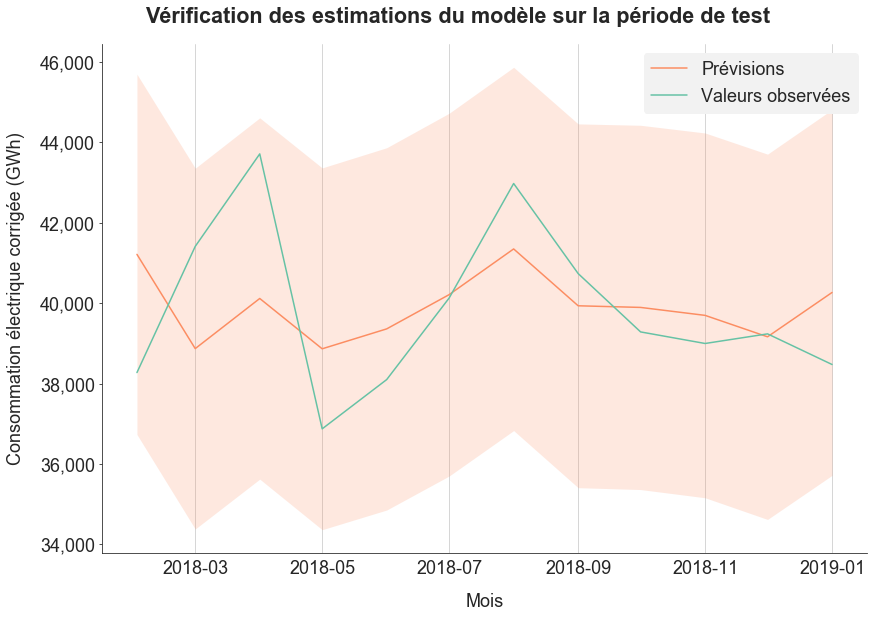

In [48]:
fig, ax = sari.plot_forecast(forecast_eval, title="Vérification des estimations du modèle sur la période de test", only_forecast=True)
ax[0].yaxis.set_major_formatter(plticker.StrMethodFormatter('{x:,.0f}'))
ax[0].set_ylabel("Consommation électrique corrigée (GWh)")
ax[0].set_xlabel("Mois")
plt.savefig("M3_g8_sarima_eval_model.png")
plt.show()

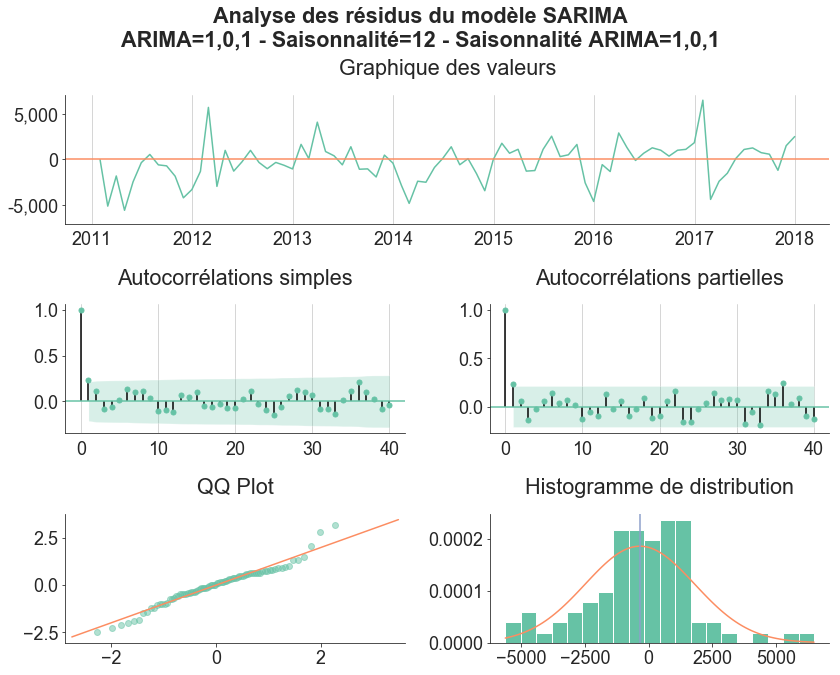

In [49]:
fig, ax = sari.check_residuals(train_size=96)
ax[0].yaxis.set_major_formatter(plticker.StrMethodFormatter('{x:,.0f}'))
plt.savefig("M3_g9_sarima_eval_residuals.png")
plt.show()

L'entraînement du modèle SARIMA (1,0,1)(1,0,1,12) sur la période 2010-2017 donne un modèle dont les coefficients sont significatifs et dont les tests valident la blancheur et l'homoscédasticité des résidus. Par contre la normalité des résidus est rejetée au seuil de 5% par les tests de Jarque-Bera et de Shapiro (mais acceptée au seuil de 2%). La vérification visuelle de leur distribution est mitigée : le graphique QQ-plot montre une distribution proche de la normalité pour les valeurs moyennes. Les difficultés d'acceptation de la normalité viennent des résidus extrêmes.

Le côté encourageant est que l'évaluation des estimations sur les valeurs de 2018 montre de meilleurs résulats (RMSE et MAPE inférieurs) que sur la période d'entraînement.  
Je valide ce modèle et je l'utilise pour estimer les valeurs en 2019. Je recalcule ses coefficients sur l'ensemble de la période 2010-2018.

In [50]:
sari.set_arima_coef(1, 0, 1, with_calculation=False)
sari.set_season_coef(1,0,1,12)
estimations2019 = sari.calcul_forecast(data_freq='M', nb_forecast=12)
estimations2019

t  observed      forecast        ci_min        ci_max
0  2019-01-31       NaN  40916.996485  36831.545815  45002.447155
1  2019-02-28       NaN  38889.060999  34789.870235  42988.251764
2  2019-03-31       NaN  40337.242478  36224.421723  44450.063234
3  2019-04-30       NaN  38278.091039  34151.749281  42404.432797
4  2019-05-31       NaN  38978.675469  34838.920605  43118.430332
5  2019-06-30       NaN  40056.080016  35903.018873  44209.141158
6  2019-07-31       NaN  41592.100428  37425.838787  45758.362070
7  2019-08-31       NaN  39799.718922  35620.361537  43979.076308
8  2019-09-30       NaN  39644.861161  35452.511781  43837.210542
9  2019-10-31       NaN  39456.188851  35250.950240  43661.427462
10 2019-11-30       NaN  38806.109095  34588.083054  43024.135136
11 2019-12-31       NaN  40075.063959  35844.351342  44305.776577

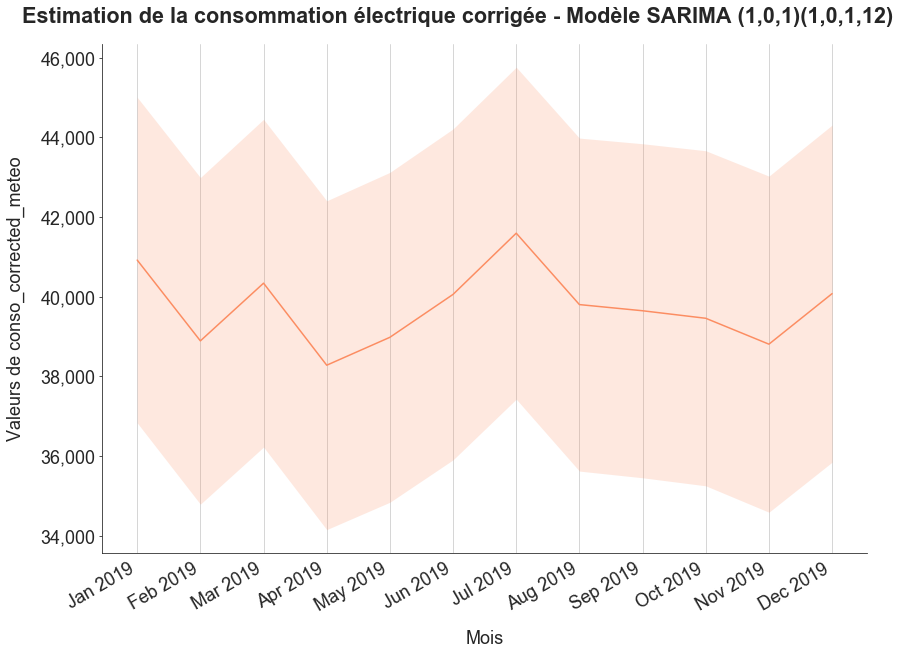

In [51]:
fig, ax = sari.plot_forecast(estimations2019, data_freq='M', title="Estimation de la consommation électrique corrigée - Modèle SARIMA (1,0,1)(1,0,1,12)", only_forecast=True)
ax[0].yaxis.set_major_formatter(plticker.StrMethodFormatter('{x:,.0f}'))
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=30, ha='right')
ax[0].set_xlabel("Mois")
#plt.savefig("M3_g10_sarima_forecast1.png")
plt.show()

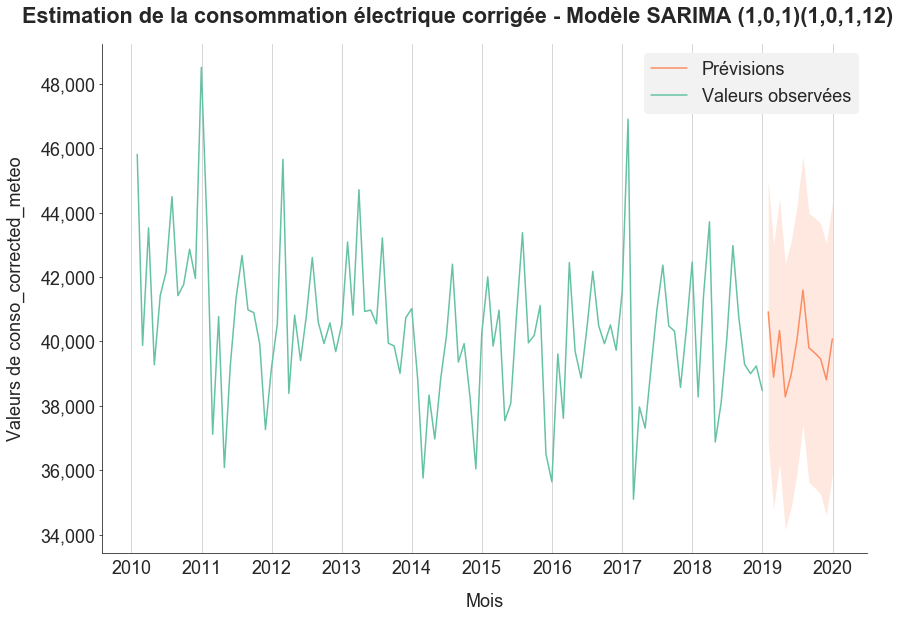

In [52]:
fig, ax = sari.plot_forecast(estimations2019, title="Estimation de la consommation électrique corrigée - Modèle SARIMA (1,0,1)(1,0,1,12)")
ax[0].yaxis.set_major_formatter(plticker.StrMethodFormatter('{x:,.0f}'))
ax[0].set_xlabel("Mois")
#plt.savefig("M3_g11_sarima_forecast2.png")
plt.show()

<a id='3_3'></a>

### 3.3. Comparaison des estimations

Je compare maintenant les estimations obtenues par lissage exponentiel et par le modèle SARIMA.

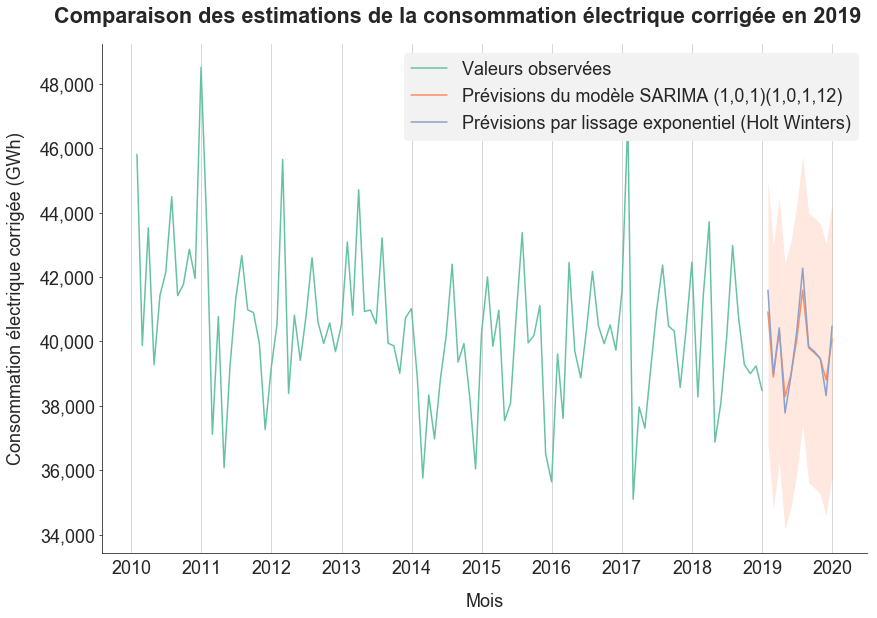

In [53]:
graph09 = sfg.MyGraph("Comparaison des estimations de la consommation électrique corrigée en 2019")
graph09.add_plot(sari.df[sari.time_index], sari.df[sari.serie_values], color=graph09.liste_couleurs[0], label="Valeurs observées")
graph09.add_plot(estimations2019.t, estimations2019.forecast, label="Prévisions du modèle SARIMA (1,0,1)(1,0,1,12)", color=graph09.liste_couleurs[1])
graph09.add_area(estimations2019.t, estimations2019.ci_min, estimations2019.ci_max, color=graph09.liste_couleurs[1])
graph09.add_plot(prevision_lissage_exponentiel.t, prevision_lissage_exponentiel.forecast, label="Prévisions par lissage exponentiel (Holt Winters)", color=graph09.liste_couleurs[2], with_grid='x', legend=True)
graph09.set_axe('y', label="Consommation électrique corrigée (GWh)", tick_dash=True, tick_labels_format=':,.0f')
graph09.set_axe('x', label="Mois")
#plt.savefig("M3_g12_comparaison_forecast1.png")
plt.show()

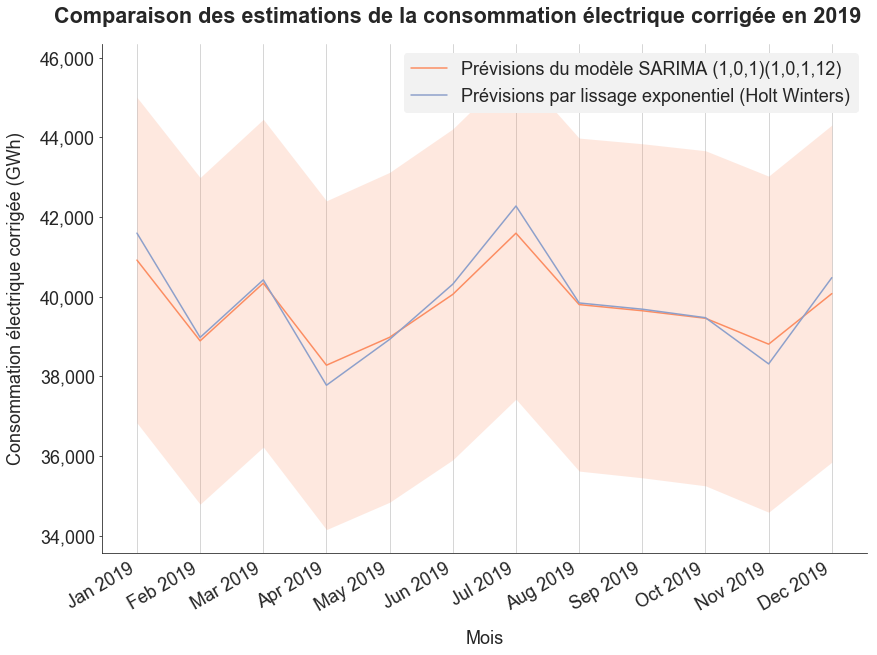

In [54]:
graph10 = sfg.MyGraph("Comparaison des estimations de la consommation électrique corrigée en 2019")
graph10.add_plot_date(estimations2019.t.dt.strftime("%b %Y"), estimations2019.forecast, label="Prévisions du modèle SARIMA (1,0,1)(1,0,1,12)", color=graph10.liste_couleurs[1])
graph10.add_area(estimations2019.t.dt.strftime("%b %Y"), estimations2019.ci_min, estimations2019.ci_max, color=graph10.liste_couleurs[1])
graph10.add_plot_date(prevision_lissage_exponentiel.t.dt.strftime("%b %Y"), prevision_lissage_exponentiel.forecast, label="Prévisions par lissage exponentiel (Holt Winters)", color=graph10.liste_couleurs[2], with_grid='x', legend=True)
graph10.set_axe('y', label="Consommation électrique corrigée (GWh)", tick_dash=True, tick_labels_format=':,.0f')
graph10.set_axe('x', label="Mois", rotation=30, ha='right')
#plt.savefig("M3_g13_comparaison_forecast2.png")
plt.show()

Les deux estimations pour 2019 sont cohérentes l'une avec l'autre. La prévision issue du modèle SARIMA est plus prudente avec des variations moins fortes d'un mois sur l'autre. Toutes les prévisions issues du lissage exponentiel sont largement comprises dans l'intervalle de confiance des valeurs estimées par le modèle SARIMA.

<a id='3_4'></a>

### 3.4. Graphiques spécifiques pour la présentation

C:\Anaconda3\envs\Jupyter\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


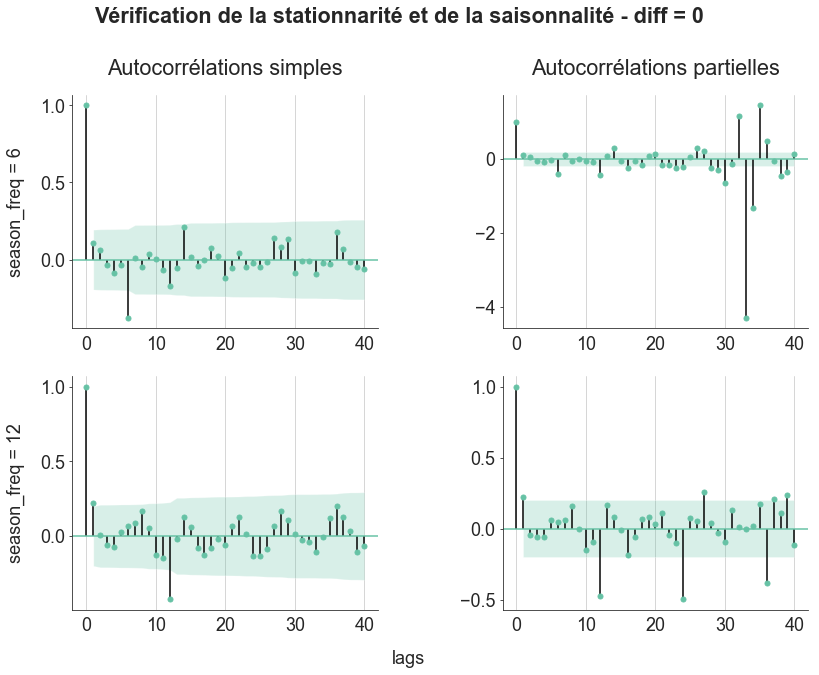

In [55]:
graph100 = sfg.MyGraph("Vérification de la stationnarité et de la saisonnalité - diff = 0", nblin=2, nbcol=2, figsize=(12,9))
df_diff = sari.df[[sari.serie_values]].copy()
i = 0
for season_freq in [6,12]:
    df_diff["season_{}".format(season_freq)] = df_diff[df_diff.columns[0]].diff(season_freq)
    sm.graphics.tsa.plot_acf(df_diff["season_{}".format(season_freq)].iloc[season_freq:], lags=40, title="", ax=graph100.ax[i*2])
    graph100.ax[i*2].spines['right'].set_visible(False)
    graph100.ax[i*2].spines['top'].set_visible(False)
    graph100.ax[i*2].grid(b=True, axis='x')
    graph100.ax[i*2].yaxis.set_tick_params(left=True)
    graph100.set_axe('y', label="season_freq = {}".format(season_freq), multi_index=i*2+1)
    if season_freq == 12:
        graph100.set_axe('x', label="lags", label_position=(1.1,0.5), multi_index=i*2+1)
    sm.graphics.tsa.plot_pacf(df_diff["season_{}".format(season_freq)].iloc[season_freq:], lags=40, title="", ax=graph100.ax[i*2+1])
    graph100.ax[i*2+1].spines['right'].set_visible(False)
    graph100.ax[i*2+1].spines['top'].set_visible(False)
    graph100.ax[i*2+1].grid(b=True, axis='x')
    graph100.ax[i*2+1].yaxis.set_tick_params(left=True)
    i += 1
graph100.ax[0].set_title("Autocorrélations simples", fontweight='normal')
graph100.ax[1].set_title("Autocorrélations partielles", fontweight='normal')
graph100.fig.tight_layout()
plt.savefig("M3_g100_autocorrelations_saisonnalité.png")
plt.show()

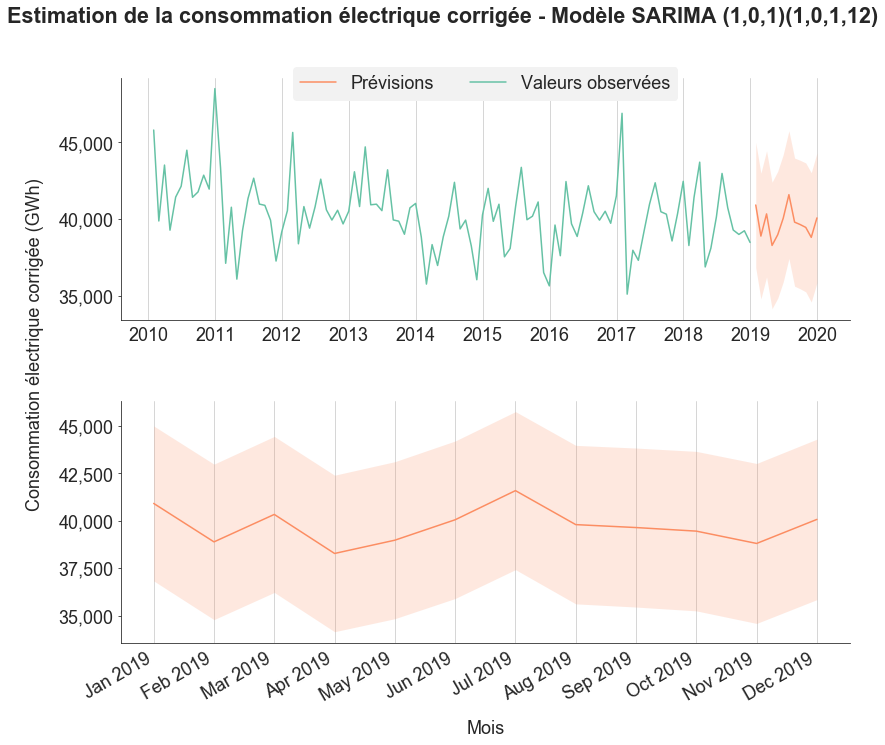

In [56]:
graph101 = sfg.MyGraph("Estimation de la consommation électrique corrigée - Modèle SARIMA (1,0,1)(1,0,1,12)", nblin=2, nbcol=1, figsize=(12,9))
graph101 = sari.plot_forecast(estimations2019, title="", ts_graph=graph101, ax_index=0)
graph101 = sari.plot_forecast(estimations2019, data_freq='M', title="", only_forecast=True, ts_graph=graph101, ax_index=1)
graph101.set_axe('y', label="Consommation électrique corrigée (GWh)", label_position=(0.5,-0.1), tick_dash=True, tick_labels_format=':,.0f')
graph101.set_axe('y', label="", tick_dash=True, tick_labels_format=':,.0f', multi_index=2)
graph101.set_axe('x', label="", multi_index=1)
graph101.set_axe('x', label="Mois", rotation=30, ha='right', multi_index=2)
graph101.set_legend(ncol=2, loc="upper center", bbox_to_anchor=(0.5,1.08), multi_index=1)
plt.savefig("M3_g101_sarima_forecast.png")
plt.show()

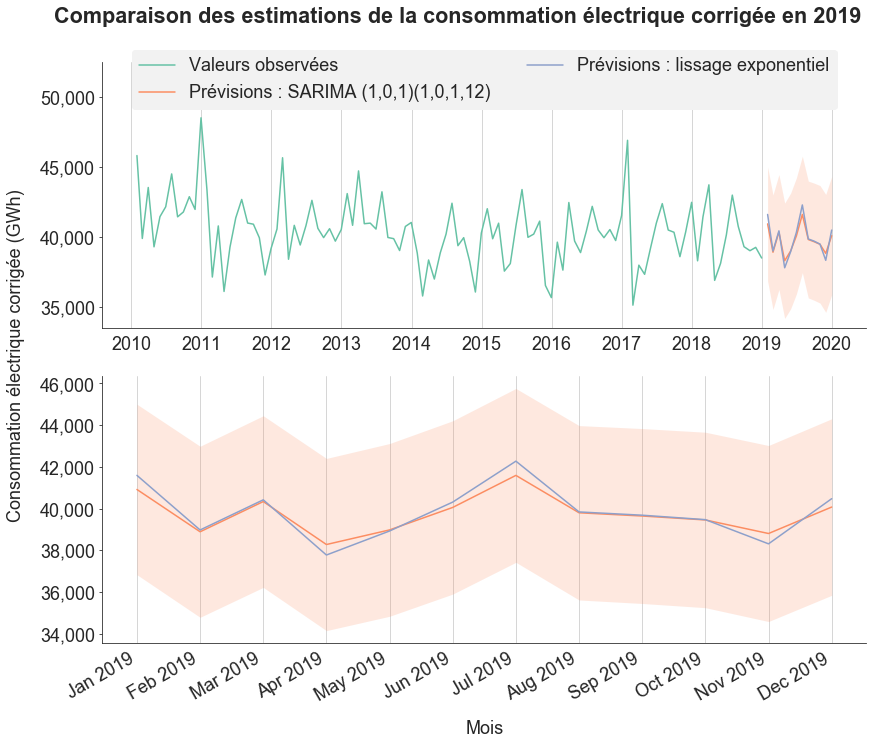

In [57]:
graph102 = sfg.MyGraph("Comparaison des estimations de la consommation électrique corrigée en 2019", nblin=2, nbcol=1, figsize=(12,9))
graph102.add_plot(sari.df[sari.time_index], sari.df[sari.serie_values], color=graph102.liste_couleurs[0], label="Valeurs observées")
graph102.add_plot(estimations2019.t, estimations2019.forecast, label="Prévisions : SARIMA (1,0,1)(1,0,1,12)", color=graph102.liste_couleurs[1])
graph102.add_area(estimations2019.t, estimations2019.ci_min, estimations2019.ci_max, color=graph102.liste_couleurs[1])
graph102.add_plot(prevision_lissage_exponentiel.t, prevision_lissage_exponentiel.forecast, label="Prévisions : lissage exponentiel", color=graph102.liste_couleurs[2], with_grid='x')
graph102.add_plot_date(estimations2019.t.dt.strftime("%b %Y"), estimations2019.forecast, label="Prévisions du modèle SARIMA (1,0,1)(1,0,1,12)", color=graph102.liste_couleurs[1], multi_index=2)
graph102.add_area(estimations2019.t.dt.strftime("%b %Y"), estimations2019.ci_min, estimations2019.ci_max, color=graph102.liste_couleurs[1], multi_index=2)
graph102.add_plot_date(prevision_lissage_exponentiel.t.dt.strftime("%b %Y"), prevision_lissage_exponentiel.forecast, label="Prévisions par lissage exponentiel (Holt Winters)", color=graph102.liste_couleurs[2], with_grid='x', multi_index=2)
graph102.set_axe('y', label="Consommation électrique corrigée (GWh)", label_position=(0.5,-0.1), tick_max=52500, tick_dash=True, tick_labels_format=':,.0f')
graph102.set_axe('y', tick_dash=True, tick_labels_format=':,.0f', multi_index=2)
graph102.set_axe('x', label="Mois", rotation=30, ha='right', multi_index=2)
graph102.set_legend(ncol=2, loc="upper center", bbox_to_anchor=(0.5,1.08), multi_index=1)
plt.savefig("M3_g102_comparaison_forecasts.png")
plt.show()